# Grade Adjusted Pace UTMB Prediction Evaluation

This notebook predicts average pace using the grade adjusted pace for the UTMB

In [288]:
import os.path
import datetime
import pandas as pd
import numpy as np
import hashlib
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

# Display all columns in Pandas
pd.set_option('display.max_columns', None) 

In [289]:
df = pd.read_csv('../../data/GAP_pace_predictions.csv', encoding = "ISO-8859-1")

In [290]:
df.head()

,Unnamed: 0,category,gender,query_AVG_Pace,query_pb,best_pb_prediction,mean_pb_average_pace,weighted_mean,euc_weighted_mean
0,0,Senior Men (23-39),Male,14.619279,13.950074,13.036878,13.565867,13.565562,13.506101
1,1,Senior Men (23-39),Male,15.464438,13.950074,12.861522,15.536794,15.536859,15.486665
2,2,Senior Men (23-39),Male,17.017172,13.950512,15.311925,16.276751,16.277098,16.063747
3,3,Masters Men 1 (40-49),Male,18.271550,15.749089,15.196247,16.285705,16.285688,16.505808
4,4,Masters Men 1 (40-49),Male,16.690929,14.369294,13.480787,14.541288,14.541413,15.033237


In [291]:
df['pb_error'] = df.best_pb_prediction - df.query_pb
df['pb_error'] = df.pb_error.abs()
df['mean_error'] = df.mean_pb_average_pace - df.query_pb
df['mean_error'] = df.mean_error.abs()
df['cos_error'] = df.weighted_mean - df.query_pb
df['cos_error'] = df.cos_error.abs()
df['euc_error'] = df.euc_weighted_mean - df.query_pb
df['euc_error'] = df.euc_error.abs()

In [292]:
df.head()

,Unnamed: 0,category,gender,query_AVG_Pace,query_pb,best_pb_prediction,mean_pb_average_pace,weighted_mean,euc_weighted_mean,pb_error,mean_error,cos_error,euc_error
0,0,Senior Men (23-39),Male,14.619279,13.950074,13.036878,13.565867,13.565562,13.506101,0.913196,0.384207,0.384512,0.443973
1,1,Senior Men (23-39),Male,15.464438,13.950074,12.861522,15.536794,15.536859,15.486665,1.088553,1.586720,1.586785,1.536590
2,2,Senior Men (23-39),Male,17.017172,13.950512,15.311925,16.276751,16.277098,16.063747,1.361412,2.326238,2.326586,2.113234
3,3,Masters Men 1 (40-49),Male,18.271550,15.749089,15.196247,16.285705,16.285688,16.505808,0.552841,0.536616,0.536600,0.756720
4,4,Masters Men 1 (40-49),Male,16.690929,14.369294,13.480787,14.541288,14.541413,15.033237,0.888507,0.171994,0.172120,0.663944


In [293]:
df = df.dropna()

In [294]:
len(df)

1634

In [295]:
df.describe()

,Unnamed: 0,query_AVG_Pace,query_pb,best_pb_prediction,mean_pb_average_pace,weighted_mean,euc_weighted_mean,pb_error,mean_error,cos_error,euc_error
count,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000
mean,816.500000,15.137414,13.988890,12.825265,14.198015,14.198013,14.219442,1.583523,1.045361,1.045120,1.033172
std,471.839485,2.443879,2.555218,2.042571,2.197320,2.197427,2.218566,1.414544,1.062956,1.062840,1.054258
min,0.000000,7.421834,7.145710,6.977774,7.682719,7.679069,7.659356,0.002772,0.000071,0.000130,0.001178
25%,408.250000,13.781799,12.257386,11.536424,12.752987,12.753904,12.824507,0.572800,0.346401,0.345807,0.328483
50%,816.500000,15.588838,14.319020,12.930850,14.887991,14.887958,14.924030,1.203702,0.764079,0.763967,0.755355
75%,1224.750000,16.877748,15.737202,14.553671,15.897861,15.898076,15.908617,2.244264,1.414097,1.414003,1.407682
max,1633.000000,21.406122,25.296476,17.307127,18.129856,18.130074,17.961844,14.904793,11.882071,11.882019,11.559565


In [296]:
df.sort_values(by = 'weighted_mean')

,Unnamed: 0,category,gender,query_AVG_Pace,query_pb,best_pb_prediction,mean_pb_average_pace,weighted_mean,euc_weighted_mean,pb_error,mean_error,cos_error,euc_error
192,192,Senior Men (23-39),Male,7.421834,7.180423,6.977774,7.682719,7.679069,7.659356,0.202648,0.502296,0.498647,0.478933
813,813,Senior Men (23-39),Male,7.600457,7.145710,7.353236,7.857635,7.855667,7.752244,0.207526,0.711925,0.709957,0.606534
928,928,Masters Men 1 (40-49),Male,7.783725,7.481216,7.494138,8.074543,8.074404,7.794377,0.012922,0.593327,0.593189,0.313161
194,194,Youth Men (20-22),Male,7.938553,7.180423,7.680335,8.153168,8.152715,7.862870,0.499912,0.972745,0.972292,0.682447
1227,1227,Senior Men (23-39),Male,8.721630,8.546558,7.888716,8.164185,8.164209,8.328115,0.657842,0.382373,0.382349,0.218443
449,449,Masters Men 1 (40-49),Male,8.845774,8.555641,8.001004,8.169531,8.169441,8.424479,0.554636,0.386109,0.386199,0.131161
193,193,Youth Men (20-22),Male,8.206899,7.180423,7.939952,8.193093,8.193211,8.103981,0.759529,1.012670,1.012788,0.923559
946,946,Senior Men (23-39),Male,7.984021,7.538354,7.506325,8.194653,8.197354,8.116264,0.032029,0.656299,0.659000,0.577910
943,943,Senior Men (23-39),Male,9.129139,9.159386,7.987314,8.229008,8.229131,8.440435,1.172072,0.930378,0.930255,0.718951
1633,1633,Senior Men (23-39),Male,8.599302,8.572921,8.084793,8.257345,8.258522,8.275042,0.488128,0.315576,0.314399,0.297879


# All

In [297]:
abestpb = sqrt(mean_squared_error(df.query_pb, df.best_pb_prediction))
ameanpb = sqrt(mean_squared_error(df.query_pb, df.mean_pb_average_pace))
aweightpb = sqrt(mean_squared_error(df.query_pb, df.weighted_mean))
aeucpb = sqrt(mean_squared_error(df.query_pb, df.euc_weighted_mean))

print('Fastest Case Error:', abestpb)
print('Mean of Cases Error:', ameanpb)
print('Weighted Mean:', aweightpb)
print('Euclidean Weighted Mean:', aeucpb)


Fastest Case Error: 2.123029471546154
Mean of Cases Error: 1.4906247890640083
Weighted Mean: 1.4903739350620748
Euclidean Weighted Mean: 1.4758811837076307


###  Percentage error

In [298]:
len(df)

1634

In [299]:
abestper = ((df.pb_error / df.query_pb) * 100).mean()
#astd = ((df.pb_error / df.query_pb) * 100).std()
ameanper = ((df.mean_error / df.query_pb) * 100).mean()
acosper = ((df.cos_error / df.query_pb) * 100).mean()
aeucper = ((df.euc_error / df.query_pb) * 100).mean()

print('Fastest Case Percentage: ', abestper)
print('Mean of Cases Percentage: ',  ameanper)
print('Cosine Mean %:',  acosper)
print('Euclidean Mean %: ', aeucper)

Fastest Case Percentage:  10.773823601828243
Mean of Cases Percentage:  7.685033817667163
Cosine Mean %: 7.6834088614141285
Euclidean Mean %:  7.601834118268265


# Male

In [300]:
male = df[df.gender == 'Male']

In [301]:
len(male)

1518

In [302]:


mbestpb = sqrt(mean_squared_error(male.query_pb, male.best_pb_prediction))
mmeanpb = sqrt(mean_squared_error(male.query_pb, male.mean_pb_average_pace))
mweightpb = sqrt(mean_squared_error(male.query_pb, male.weighted_mean))
meucpb = sqrt(mean_squared_error(male.query_pb, male.euc_weighted_mean))

print('Male Fastest Case Error:', mbestpb)
print('Male Mean of Cases Error:', mmeanpb)
print('Male Weighted Mean of Cases Error:', mweightpb)
print('Male Euclidean Weighted Mean of Cases Error:', meucpb)

Male Fastest Case Error: 2.1161195734029072
Male Mean of Cases Error: 1.5118545010176947
Male Weighted Mean of Cases Error: 1.5116017629625287
Male Euclidean Weighted Mean of Cases Error: 1.4970998476872046


###  Percentage error

In [303]:
mbestper = ((male.pb_error / male.query_pb) * 100).mean()
mmeanper = ((male.mean_error / male.query_pb) * 100).mean()
mcosper = ((male.cos_error / male.query_pb) * 100).mean()
meucper = ((male.euc_error / male.query_pb) * 100).mean()

print('Fastest Case Percentage: ', mbestper)
print('Mean of Cases Percentage: ',  mmeanper)
print('Cosine Mean %:',  mcosper)
print('Euclidean Mean %: ', meucper)

Fastest Case Percentage:  10.699073145710312
Mean of Cases Percentage:  7.807440639833699
Cosine Mean %: 7.8059914709403655
Euclidean Mean %:  7.723297751788861


# Female

In [304]:
female = df[df.gender == 'Female']

In [305]:
len(female)

116

In [306]:


fbestpb = sqrt(mean_squared_error(female.query_pb, female.best_pb_prediction))
fmeanpb = sqrt(mean_squared_error(female.query_pb, female.mean_pb_average_pace))
fweightpb = sqrt(mean_squared_error(female.query_pb, female.weighted_mean))
feucpb = sqrt(mean_squared_error(female.query_pb, female.euc_weighted_mean))

print('Female Fastest Case Error:', fbestpb)
print('Female Mean of Cases Error:', fmeanpb)
print('Female Weighted Mean of Cases Error', fweightpb)
print('Female Euclidean Weighted Mean of Cases Error:', feucpb)

Female Fastest Case Error: 2.211464777597363
Female Mean of Cases Error: 1.178059533885818
Female Weighted Mean of Cases Error 1.1778329211291807
Female Euclidean Weighted Mean of Cases Error: 1.1630615607441361


###  Percentage error

In [307]:
fbestper = ((female.pb_error / female.query_pb) * 100).mean()
fmeanper = ((female.mean_error / female.query_pb) * 100).mean()
fcosper = ((female.cos_error / female.query_pb) * 100).mean()
feucper = ((female.euc_error / female.query_pb) * 100).mean()

print('Fastest Case Percentage: ', fbestper)
print('Mean of Cases Percentage: ',  fmeanper)
print('Cosine Mean %:',  fcosper)
print('Euclidean Mean %: ', feucper)

Fastest Case Percentage:  11.752023536199
Mean of Cases Percentage:  6.083192817246512
Cosine Mean %: 6.07926747123461
Euclidean Mean %:  6.012335879610858


In [308]:
mean = [ameanpb, mmeanpb, fmeanpb ]
best = [abestpb, mbestpb, fbestpb]
w_mean = [aweightpb, mweightpb, fweightpb]
euc_mean =[aeucpb, meucpb, feucpb]

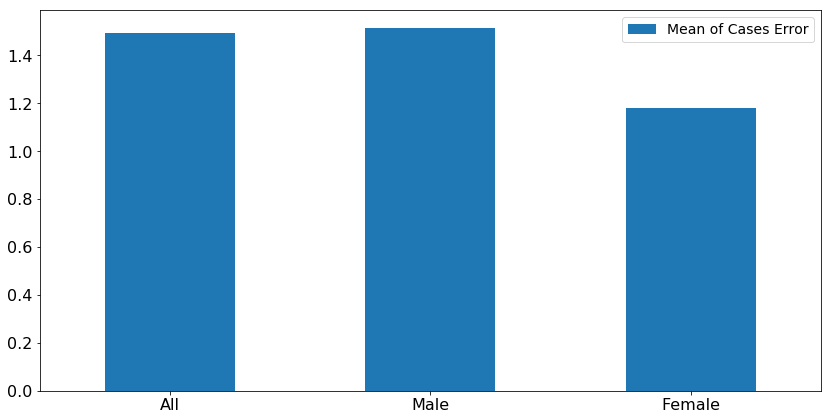

In [309]:
index = ['All', 'Male',  'Female']
gra = pd.DataFrame({'Mean of Cases Error': mean}, index=index)
ax = gra.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

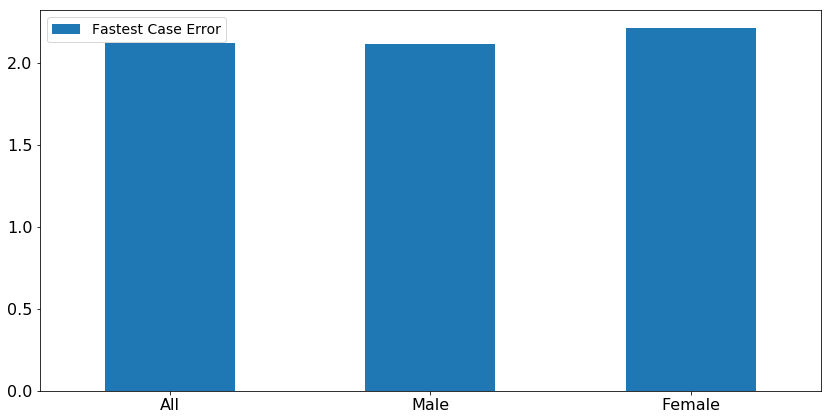

In [310]:
index = ['All', 'Male', 'Female']
gra2 = pd.DataFrame({'Fastest Case Error': best}, index=index)
ax = gra2.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

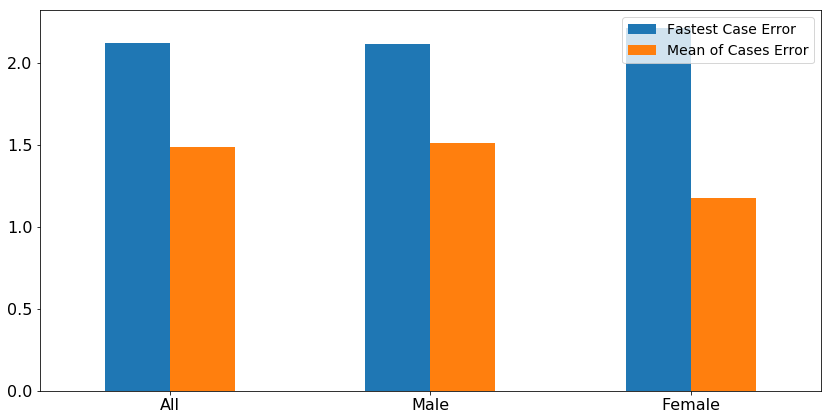

In [311]:
index = ['All', 'Male', 'Female']
gra1 = pd.DataFrame({'Mean of Cases Error': mean, 'Fastest Case Error': best}, index=index)
ax = gra1.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

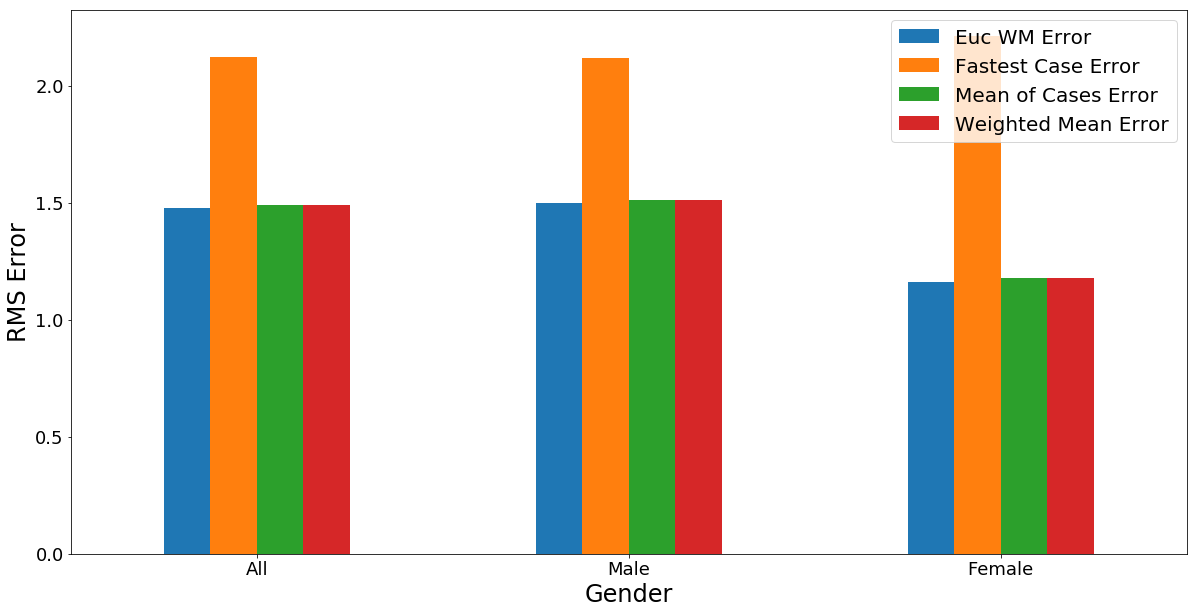

In [312]:
index = ['All', 'Male', 'Female']
gra_w = pd.DataFrame({'Mean of Cases Error': mean, 'Fastest Case Error': best, 'Weighted Mean Error': w_mean, 'Euc WM Error': euc_mean}, index=index)
ax = gra_w.plot.bar(figsize=(20, 10), fontsize=18, rot=0)
ax.set_ylabel('RMS Error', fontsize = 24)
ax.set_xlabel('Gender', fontsize = 24)
ax.legend(fontsize = 20)

In [313]:
mean = [ameanper, mmeanper, fmeanper ]
best = [abestper, mbestper, fbestper]
w_mean = [acosper, mcosper, fcosper]
euc_mean =[aeucper, meucper, feucper]

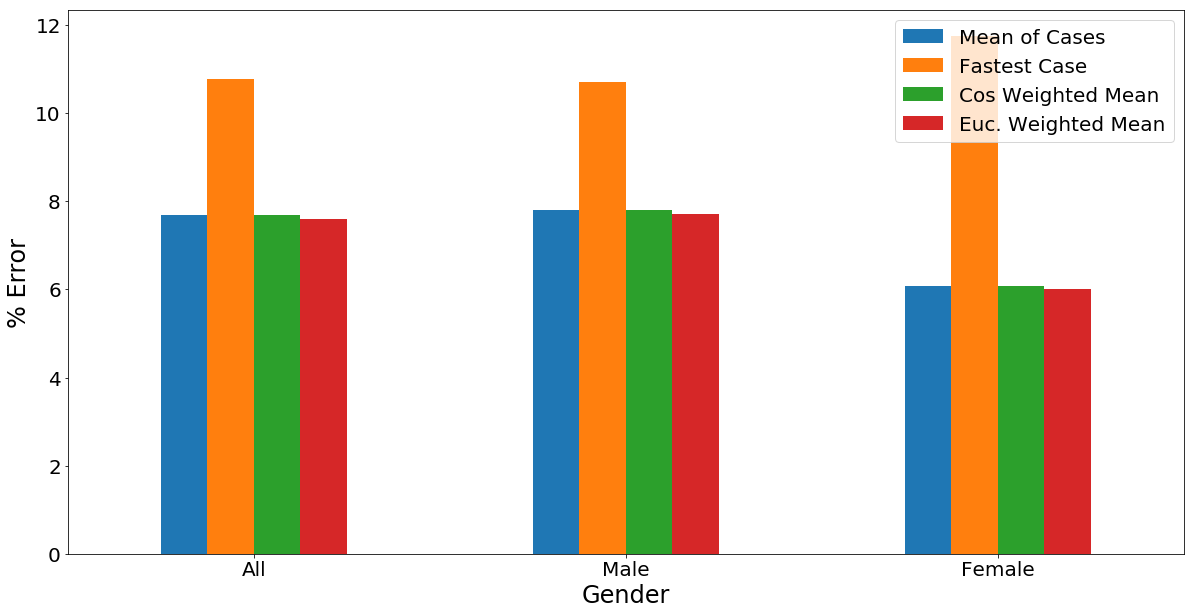

In [314]:
index = ['All', 'Male', 'Female']
gra_w = pd.DataFrame({'Euc. Weighted Mean': euc_mean, 'Fastest Case': best, 'Cos Weighted Mean': w_mean, 'Mean of Cases': mean}, index=index)
gra_w = gra_w[['Mean of Cases', 'Fastest Case', 'Cos Weighted Mean', 'Euc. Weighted Mean']]
ax = gra_w.plot.bar(figsize=(20, 10), fontsize=20, rot=0)
ax.set_ylabel('% Error', fontsize = 24)
ax.set_xlabel('Gender', fontsize = 24)
ax.legend(fontsize = 20)

In [315]:
euc_mean

[7.601834118268265, 7.723297751788861, 6.012335879610858]

# Categories

In [316]:
sen = df[df.category == 'Senior Men (23-39)']

mas = df[df.category == 'Masters Men 1 (40-49)']

mas2 = df[df.category == 'Masters Men 2 (50-59)']

mas3 = df[df.category == 'Masters Men 3 (60-69)']

wom1 = df[df.category == 'Masters Women 1 (40-49)']

wom2 = df[df.category == 'Masters Women 2 (50-59)']

senW = df[df.category == 'Senior Women (23-39)']

you = df[df.category == 'Youth Men (20-22)']

In [317]:

snrB = sqrt(mean_squared_error(sen.query_pb, sen.best_pb_prediction))
snrM = sqrt(mean_squared_error(sen.query_pb, sen.mean_pb_average_pace))
snrw = sqrt(mean_squared_error(sen.query_pb, sen.weighted_mean))
snrE = sqrt(mean_squared_error(sen.query_pb, sen.euc_weighted_mean))

mas1B = sqrt(mean_squared_error(mas.query_pb, mas.best_pb_prediction))
mas1M = sqrt(mean_squared_error(mas.query_pb, mas.mean_pb_average_pace))
mas1BW = sqrt(mean_squared_error(mas.query_pb, mas.weighted_mean))
mas1ME = sqrt(mean_squared_error(mas.query_pb, mas.euc_weighted_mean))

mas2B = sqrt(mean_squared_error(mas2.query_pb, mas2.best_pb_prediction))
mas2M = sqrt(mean_squared_error(mas2.query_pb, mas2.mean_pb_average_pace))

mas3B = sqrt(mean_squared_error(mas3.query_pb, mas3.best_pb_prediction))
mas3M = sqrt(mean_squared_error(mas3.query_pb, mas3.mean_pb_average_pace))

wom1B = sqrt(mean_squared_error(wom1.query_pb, wom1.best_pb_prediction))
wom1M = sqrt(mean_squared_error(wom1.query_pb, wom1.mean_pb_average_pace))

wom2B = sqrt(mean_squared_error(wom2.query_pb, wom2.best_pb_prediction))
wom2M = sqrt(mean_squared_error(wom2.query_pb, wom2.mean_pb_average_pace))

senWB = sqrt(mean_squared_error(senW.query_pb, senW.best_pb_prediction))
senWM = sqrt(mean_squared_error(senW.query_pb, senW.mean_pb_average_pace))

youB = sqrt(mean_squared_error(you.query_pb, you.best_pb_prediction))
youM = sqrt(mean_squared_error(you.query_pb, you.mean_pb_average_pace))

print('Senior Men Fastest Case Error:', snrB)
print('Senior Men Mean of Cases Error:', snrM)
print('Master 1 Fastest Case Error:', mas1B)
print('Master 1 Mean of Cases Error:', mas1M)
print('Master 2 Fastest Case Error:', mas2B)
print('Master 2 Mean of Cases Error:', mas2M)
print('Master 3 Fastest Case Error:', mas3B)
print('Master 3 Mean of Cases Error:', mas3M)
print('Master Women 1 Fastest Case Error:', wom1B)
print('Master Women 1 Mean of Cases Error:', wom1M)
print('Master Women 2 Fastest Case Error:', wom2B)
print('Master Women 2 Mean of Cases Error:', wom2M)
print('Senior Women Fastest Case Error:', senWB)
print('Senior Women Mean of Cases Error:', senWM)
print('Youth Men Fastest Case Error:', youB)
print('Youth Men Mean of Cases Error:', youM)

Senior Men Fastest Case Error: 1.9399209361514722
Senior Men Mean of Cases Error: 1.5837300813249897
Master 1 Fastest Case Error: 2.03731951152535
Master 1 Mean of Cases Error: 1.3527484985184155
Master 2 Fastest Case Error: 2.569569098525529
Master 2 Mean of Cases Error: 1.7260978072554327
Master 3 Fastest Case Error: 1.928990909900508
Master 3 Mean of Cases Error: 1.0418643704641304
Master Women 1 Fastest Case Error: 2.182435267900185
Master Women 1 Mean of Cases Error: 0.9984134873913001
Master Women 2 Fastest Case Error: 2.4431549449943257
Master Women 2 Mean of Cases Error: 1.4045792118317395
Senior Women Fastest Case Error: 2.1574585405923274
Senior Women Mean of Cases Error: 1.264761203532021
Youth Men Fastest Case Error: 1.8733660248050787
Youth Men Mean of Cases Error: 3.025799144463563


In [318]:
mean1 = [snrM, mas1M, mas2M, mas3M, wom1M, wom2M, senWM]
best1 = [snrB, mas1B, mas2B, mas3B, wom1B, wom2B, senWB]

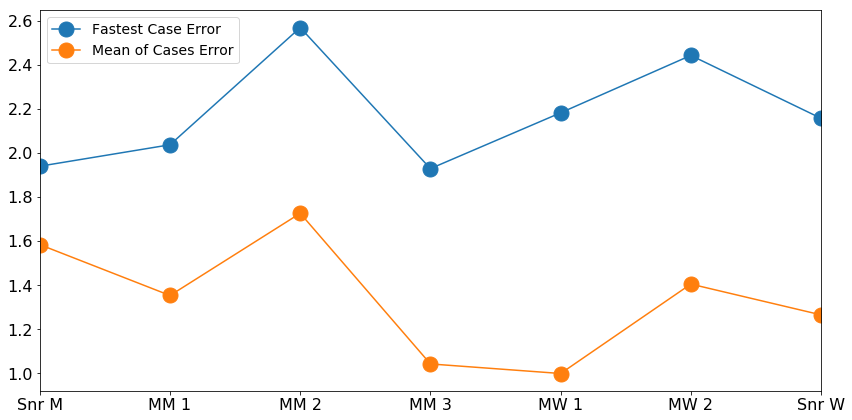

In [319]:
index = ['Snr M', 'MM 1', 'MM 2', 'MM 3', 'MW 1', 'MW 2', 'Snr W']
gra3 = pd.DataFrame({'Mean of Cases Error': mean1, 'Fastest Case Error': best1}, index=index)
ax = gra3.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

# Ability

In [320]:
g9 = df[(df.query_pb <= 9)]
g11 = df[(df.query_pb > 9) & (df.query_pb <= 11)]
g13 = df[(df.query_pb > 11) & (df.query_pb <= 13)]
g15 = df[(df.query_pb > 13) & (df.query_pb <= 15)]
g17 = df[(df.query_pb > 15) & (df.query_pb <= 17)]
g19 = df[(df.query_pb > 17)]

## Bin counts

In [321]:
g9count = g9.shape[0]
g11count = g11.shape[0]
g13count = g13.shape[0]
g15count = g15.shape[0]
g17count = g17.shape[0]
g19count = g19.shape[0]

In [322]:
print(g9count)
print(g11count)
print(g13count) 
print(g15count)
print(g17count)
print(g19count) 

70
156
313
463
478
154


In [323]:
count = [g9count, g11count, g13count, g15count, g17count, g19count]

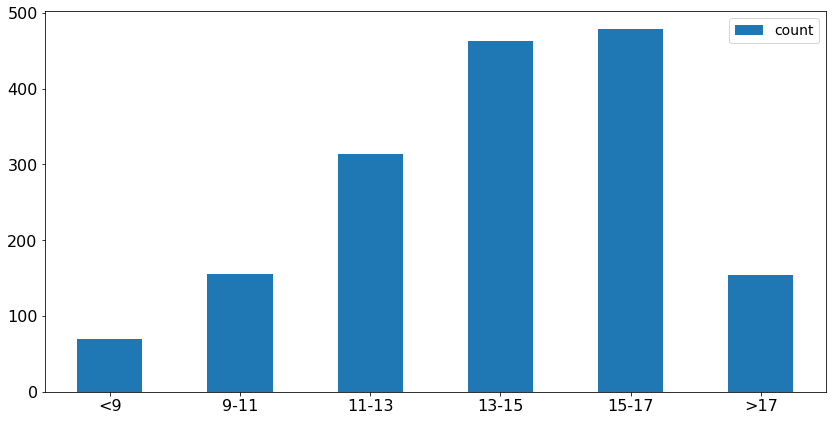

In [324]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra7 = pd.DataFrame({'count': count}, index=index)
ax = gra7.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [325]:


g9B = sqrt(mean_squared_error(g9.query_pb, g9.best_pb_prediction))
g9M = sqrt(mean_squared_error(g9.query_pb, g9.mean_pb_average_pace))
g9W = sqrt(mean_squared_error(g9.query_pb, g9.weighted_mean))
g9E = sqrt(mean_squared_error(g9.query_pb, g9.euc_weighted_mean))

g11B = sqrt(mean_squared_error(g11.query_pb, g11.best_pb_prediction))
g11M = sqrt(mean_squared_error(g11.query_pb, g11.mean_pb_average_pace))
g11W = sqrt(mean_squared_error(g11.query_pb, g11.weighted_mean))
g11E = sqrt(mean_squared_error(g11.query_pb, g11.euc_weighted_mean))

g13B = sqrt(mean_squared_error(g13.query_pb, g13.best_pb_prediction))
g13M = sqrt(mean_squared_error(g13.query_pb, g13.mean_pb_average_pace))
g13W = sqrt(mean_squared_error(g13.query_pb, g13.weighted_mean))
g13E = sqrt(mean_squared_error(g13.query_pb, g13.euc_weighted_mean))

g15B = sqrt(mean_squared_error(g15.query_pb, g15.best_pb_prediction))
g15M = sqrt(mean_squared_error(g15.query_pb, g15.mean_pb_average_pace))
g15W = sqrt(mean_squared_error(g15.query_pb, g15.weighted_mean))
g15E = sqrt(mean_squared_error(g15.query_pb, g15.euc_weighted_mean))

g17B = sqrt(mean_squared_error(g17.query_pb, g17.best_pb_prediction))
g17M = sqrt(mean_squared_error(g17.query_pb, g17.mean_pb_average_pace))
g17W = sqrt(mean_squared_error(g17.query_pb, g17.weighted_mean))
g17E = sqrt(mean_squared_error(g17.query_pb, g17.euc_weighted_mean))

g19B = sqrt(mean_squared_error(g19.query_pb, g19.best_pb_prediction))
g19M = sqrt(mean_squared_error(g19.query_pb, g19.mean_pb_average_pace))
g19W = sqrt(mean_squared_error(g19.query_pb, g19.weighted_mean))
g19E = sqrt(mean_squared_error(g19.query_pb, g19.euc_weighted_mean))


print('U9 Fastest Case Error:', g9B)
print('U9 Mean of Cases Error:', g9M)
print('9-11 Fastest Case Error:', g11B)
print('9-11 Mean of Cases Error:', g11M)
print('11-13 Fastest Case Error:', g13B)
print('11-13 Mean of Cases Error:', g13M)
print('13-15 Fastest Case Error:', g15B)
print('13-15 Mean of Cases Error:', g15M)
print('15-17 Fastest Case Error:', g17B)
print('15-17 Mean of Cases Error:', g17M)
print('O17 Fastest Case Error:', g19B)
print('017 Mean of Cases Error:', g19M)

U9 Fastest Case Error: 0.5124618307650379
U9 Mean of Cases Error: 1.0032694288589945
9-11 Fastest Case Error: 1.310007423394289
9-11 Mean of Cases Error: 1.8950710787079919
11-13 Fastest Case Error: 1.278052553545426
11-13 Mean of Cases Error: 1.6483282104771242
13-15 Fastest Case Error: 1.6983503077275706
13-15 Mean of Cases Error: 1.2301088833734988
15-17 Fastest Case Error: 2.325619694879333
15-17 Mean of Cases Error: 0.8737435825272494
O17 Fastest Case Error: 4.1456868886101566
017 Mean of Cases Error: 2.653170274529408


In [326]:
mean2 = [g9M, g11M, g13M, g15M, g17M, g19M]
best2 = [g9B, g11B, g13B, g15B, g17B, g19B]
wei2 = [g9W, g11W, g13W, g15W, g17W, g19W]
euc2 = [g9E, g11E, g13E, g15E, g17E, g19E]

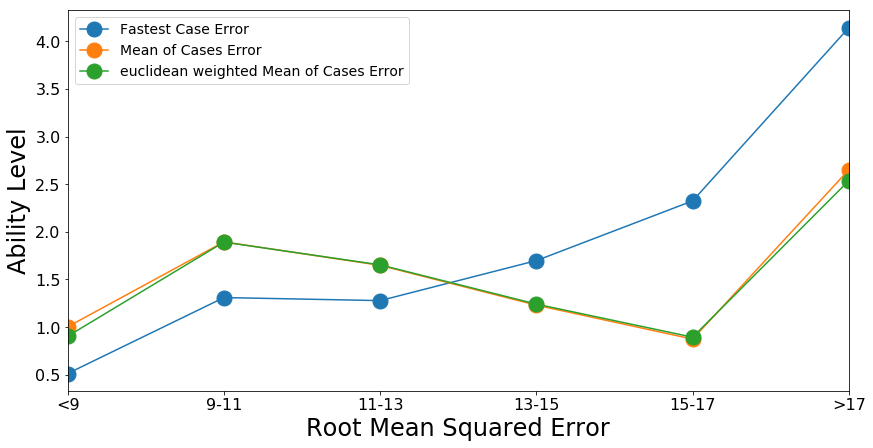

In [327]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra4 = pd.DataFrame({'Mean of Cases Error': mean2, 'Fastest Case Error': best2, 'euclidean weighted Mean of Cases Error': euc2}, index=index)
ax = gra4.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.set_ylabel('Ability Level', fontsize = 24)
ax.set_xlabel('Root Mean Squared Error', fontsize = 24)
ax.legend(fontsize = 14)

# Male Ability

In [328]:
maleg9 = male[(male.query_pb <= 9)]
maleg11 = male[(male.query_pb > 9) & (male.query_pb <= 11)]
maleg13 = male[(male.query_pb > 11) & (male.query_pb <= 13)]
maleg15 = male[(male.query_pb > 13) & (male.query_pb <= 15)]
maleg17 = male[(male.query_pb > 15) & (male.query_pb <= 17)]
maleg19 = male[(male.query_pb > 17)]

## Bin counts

In [329]:
maleg9count = maleg9.shape[0]
maleg11count = maleg11.shape[0]
maleg13count = maleg13.shape[0]
maleg15count = maleg15.shape[0]
maleg17count = maleg17.shape[0]
maleg19count = maleg19.shape[0]

In [330]:
print(maleg9count) 
print(maleg11count )
print(maleg13count)
print(maleg15count) 
print(maleg17count) 
print(maleg19count) 

69
135
297
435
437
145


In [331]:
count1 = [maleg9count, maleg11count, maleg13count, maleg15count, maleg17count, maleg19count]

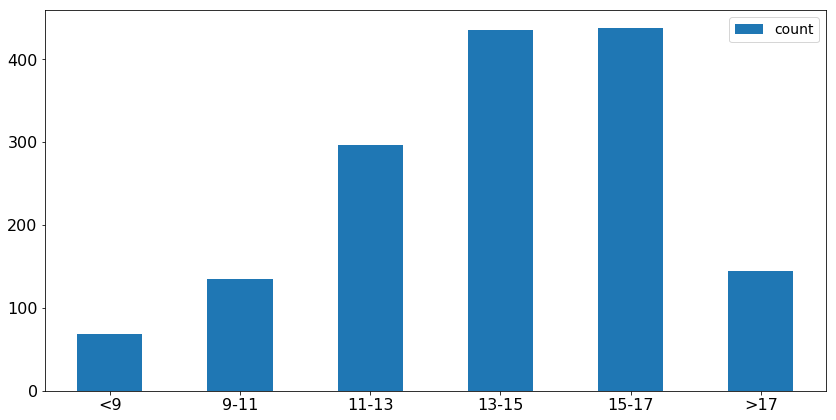

In [332]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra8 = pd.DataFrame({'count': count1}, index=index)
ax = gra8.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [333]:


maleg9B = sqrt(mean_squared_error(maleg9.query_pb, maleg9.best_pb_prediction))
maleg9M = sqrt(mean_squared_error(maleg9.query_pb, maleg9.mean_pb_average_pace))

maleg11B = sqrt(mean_squared_error(maleg11.query_pb, maleg11.best_pb_prediction))
maleg11M = sqrt(mean_squared_error(maleg11.query_pb, maleg11.mean_pb_average_pace))

maleg13B = sqrt(mean_squared_error(maleg13.query_pb, maleg13.best_pb_prediction))
maleg13M = sqrt(mean_squared_error(maleg13.query_pb, maleg13.mean_pb_average_pace))

maleg15B = sqrt(mean_squared_error(maleg15.query_pb, maleg15.best_pb_prediction))
maleg15M = sqrt(mean_squared_error(maleg15.query_pb, maleg15.mean_pb_average_pace))

maleg17B = sqrt(mean_squared_error(maleg17.query_pb, maleg17.best_pb_prediction))
maleg17M = sqrt(mean_squared_error(maleg17.query_pb, maleg17.mean_pb_average_pace))

maleg19B = sqrt(mean_squared_error(maleg19.query_pb, maleg19.best_pb_prediction))
maleg19M = sqrt(mean_squared_error(maleg19.query_pb, maleg19.mean_pb_average_pace))

maleg9W = sqrt(mean_squared_error(maleg9.query_pb, maleg9.weighted_mean))
maleg9E = sqrt(mean_squared_error(maleg9.query_pb, maleg9.euc_weighted_mean))

maleg11W = sqrt(mean_squared_error(maleg11.query_pb, maleg11.weighted_mean))
maleg11E = sqrt(mean_squared_error(maleg11.query_pb, maleg11.euc_weighted_mean))

maleg13W = sqrt(mean_squared_error(maleg13.query_pb, maleg13.weighted_mean))
maleg13E = sqrt(mean_squared_error(maleg13.query_pb, maleg13.euc_weighted_mean))

maleg15W = sqrt(mean_squared_error(maleg15.query_pb, maleg15.weighted_mean))
maleg15E = sqrt(mean_squared_error(maleg15.query_pb, maleg15.euc_weighted_mean))

maleg17W = sqrt(mean_squared_error(maleg17.query_pb, maleg17.weighted_mean))
maleg17E = sqrt(mean_squared_error(maleg17.query_pb, maleg17.euc_weighted_mean))

maleg19W = sqrt(mean_squared_error(maleg19.query_pb, maleg19.weighted_mean))
maleg19E = sqrt(mean_squared_error(maleg19.query_pb, maleg19.euc_weighted_mean))


print('Male U9 Fastest Case Error:', maleg9B)
print('Male U9 Mean of Cases Error:', maleg9M)
print('Male 9-11 Fastest Case Error:', maleg11B)
print('Male 9-11 Mean of Cases Error:', maleg11M)
print('Male 11-13 Fastest Case Error:', maleg13B)
print('Male 11-13 Mean of Cases Error:', maleg13M)
print('Male 13-15 Fastest Case Error:', maleg15B)
print('Male 13-15 Mean of Cases Error:', maleg15M)
print('Male 15-17 Fastest Case Error:', maleg17B)
print('Male 15-17 Mean of Cases Error:', maleg17M)
print('Male O17 Fastest Case Error:', maleg19B)
print('Male 017 Mean of Cases Error:', maleg19M)

Male U9 Fastest Case Error: 0.5156783061190482
Male U9 Mean of Cases Error: 1.007314711771508
Male 9-11 Fastest Case Error: 1.3790827401074768
Male 9-11 Mean of Cases Error: 1.9740678004659895
Male 11-13 Fastest Case Error: 1.26930490201332
Male 11-13 Mean of Cases Error: 1.6544510018980951
Male 13-15 Fastest Case Error: 1.5902462187254647
Male 13-15 Mean of Cases Error: 1.233389250447299
Male 15-17 Fastest Case Error: 2.3284943769257964
Male 15-17 Mean of Cases Error: 0.8835292438784235
Male O17 Fastest Case Error: 4.213696778012109
Male 017 Mean of Cases Error: 2.700921173801519


###  Percentage

In [334]:
mgb9_per = ((maleg9.pb_error / maleg9.query_pb) * 100).mean()
mgm9_per = ((maleg9.mean_error / maleg9.query_pb) * 100).mean()

mgb11_per = ((maleg11.pb_error / maleg11.query_pb) * 100).mean()
mgm11_per = ((maleg11.mean_error / maleg11.query_pb) * 100).mean()

mgb13_per = ((maleg13.pb_error / maleg13.query_pb) * 100).mean()
mgm13_per = ((maleg13.mean_error / maleg13.query_pb) * 100).mean()

mgb15_per = ((maleg15.pb_error / maleg15.query_pb) * 100).mean()
mgm15_per = ((maleg15.mean_error / maleg15.query_pb) * 100).mean()

mgb17_per = ((maleg17.pb_error / maleg17.query_pb) * 100).mean()
mgm17_per = ((maleg17.mean_error / maleg17.query_pb) * 100).mean()

mgb19_per = ((maleg19.pb_error / maleg19.query_pb) * 100).mean()
mgm19_per = ((maleg19.mean_error / maleg19.query_pb) * 100).mean()

print(mgb9_per)
print(mgm9_per)
print(mgb11_per)
print(mgm11_per)
print(mgb13_per)
print(mgm13_per)
print(mgb15_per)
print(mgm15_per)
print(mgb17_per)
print(mgm17_per)
print(mgb19_per)
print(mgm19_per)

4.753912166465262
7.740468707184911
10.266668990222342
13.400472972280719
8.252487133210295
10.064041575558669
9.248819163465123
7.132123356649096
11.9151688181614
4.332013095567694
19.627717198722923
10.51003426460372


In [335]:
mean3 = [maleg9M, maleg11M, maleg13M, maleg15M, maleg17M, maleg19M]
best3 = [maleg9B, maleg11B, maleg13B, maleg15B, maleg17B, maleg19B]
wei3 = [maleg9W, maleg11W, maleg13W, maleg15W, maleg17W, maleg19W]
euc3 = [maleg9E, maleg11E, maleg13E, maleg15E, maleg17E, maleg19E]

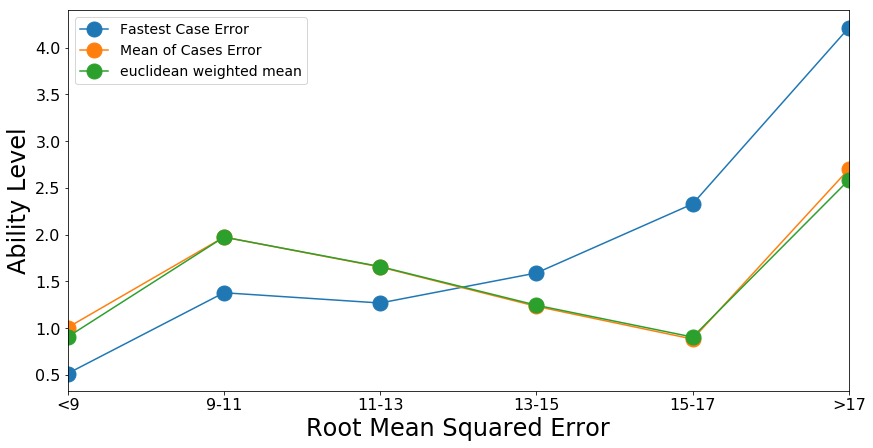

In [336]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra5 = pd.DataFrame({'Mean of Cases Error': mean3, 'Fastest Case Error': best3,  'euclidean weighted mean': euc3}, index=index)
ax = gra5.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.set_ylabel('Ability Level', fontsize = 24)
ax.set_xlabel('Root Mean Squared Error', fontsize = 24)
ax.legend(fontsize = 14)

# Female Ability

In [337]:
femaleg9 = female[(female.query_pb <= 9)]
femaleg11 = female[(female.query_pb > 9) & (female.query_pb <= 11)]
femaleg13 = female[(female.query_pb > 11) & (female.query_pb <= 13)]
femaleg15 = female[(female.query_pb > 13) & (female.query_pb <= 15)]
femaleg17 = female[(female.query_pb > 15) & (female.query_pb <= 17)]
femaleg19 = female[(female.query_pb > 17)]

## Bin counts

In [338]:
femaleg9count = femaleg9.shape[0]
femaleg11count = femaleg11.shape[0]
femaleg13count = femaleg13.shape[0]
femaleg15count = femaleg15.shape[0]
femaleg17count = femaleg17.shape[0]
femaleg19count = femaleg19.shape[0]

In [339]:
print(femaleg9count) 
print(femaleg11count )
print(femaleg13count)
print(femaleg15count) 
print(femaleg17count) 
print(femaleg19count) 

1
21
16
28
41
9


In [340]:
count1 = [femaleg9count, femaleg11count, femaleg13count, femaleg15count, femaleg17count, femaleg19count]

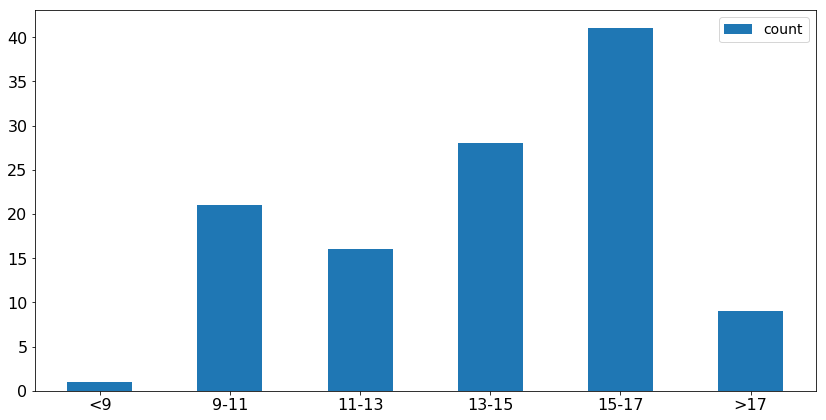

In [341]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra9 = pd.DataFrame({'count': count1}, index=index)
ax = gra9.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [342]:


femaleg9B = sqrt(mean_squared_error(femaleg9.query_pb, femaleg9.best_pb_prediction))
femaleg9M = sqrt(mean_squared_error(femaleg9.query_pb, femaleg9.mean_pb_average_pace))

femaleg11B = sqrt(mean_squared_error(femaleg11.query_pb, femaleg11.best_pb_prediction))
femaleg11M = sqrt(mean_squared_error(femaleg11.query_pb, femaleg11.mean_pb_average_pace))

femaleg13B = sqrt(mean_squared_error(femaleg13.query_pb, femaleg13.best_pb_prediction))
femaleg13M = sqrt(mean_squared_error(femaleg13.query_pb, femaleg13.mean_pb_average_pace))

femaleg15B = sqrt(mean_squared_error(femaleg15.query_pb, femaleg15.best_pb_prediction))
femaleg15M = sqrt(mean_squared_error(femaleg15.query_pb, femaleg15.mean_pb_average_pace))

femaleg17B = sqrt(mean_squared_error(femaleg17.query_pb, femaleg17.best_pb_prediction))
femaleg17M = sqrt(mean_squared_error(femaleg17.query_pb, femaleg17.mean_pb_average_pace))

femaleg19B = sqrt(mean_squared_error(femaleg19.query_pb, femaleg19.best_pb_prediction))
femaleg19M = sqrt(mean_squared_error(femaleg19.query_pb, femaleg19.mean_pb_average_pace))

femaleg9W = sqrt(mean_squared_error(femaleg9.query_pb, femaleg9.weighted_mean))
femaleg9E = sqrt(mean_squared_error(femaleg9.query_pb, femaleg9.euc_weighted_mean))

femaleg11W = sqrt(mean_squared_error(femaleg11.query_pb, femaleg11.weighted_mean))
femaleg11E = sqrt(mean_squared_error(femaleg11.query_pb, femaleg11.euc_weighted_mean))

femaleg13W = sqrt(mean_squared_error(femaleg13.query_pb, femaleg13.weighted_mean))
femaleg13E = sqrt(mean_squared_error(femaleg13.query_pb, femaleg13.euc_weighted_mean))

femaleg15W = sqrt(mean_squared_error(femaleg15.query_pb, femaleg15.weighted_mean))
femaleg15E = sqrt(mean_squared_error(femaleg15.query_pb, femaleg15.euc_weighted_mean))

femaleg17W = sqrt(mean_squared_error(femaleg17.query_pb, femaleg17.weighted_mean))
femaleg17E = sqrt(mean_squared_error(femaleg17.query_pb, femaleg17.euc_weighted_mean))

femaleg19W = sqrt(mean_squared_error(femaleg19.query_pb, femaleg19.weighted_mean))
femaleg19E = sqrt(mean_squared_error(femaleg19.query_pb, femaleg19.euc_weighted_mean))


print('female U9 Fastest Case Error:', femaleg9B)
print('female U9 Mean of Cases Error:', femaleg9M)
print('female 9-11 Fastest Case Error:', femaleg11B)
print('female 9-11 Mean of Cases Error:', femaleg11M)
print('female 11-13 Fastest Case Error:', femaleg13B)
print('female 11-13 Mean of Cases Error:', femaleg13M)
print('female 13-15 Fastest Case Error:', femaleg15B)
print('female 13-15 Mean of Cases Error:', femaleg15M)
print('female 15-17 Fastest Case Error:', femaleg17B)
print('female 15-17 Mean of Cases Error:', femaleg17M)
print('female O17 Fastest Case Error:', femaleg19B)
print('female 017 Mean of Cases Error:', femaleg19M)

female U9 Fastest Case Error: 0.1855666905693507
female U9 Mean of Cases Error: 0.667342649448452
female 9-11 Fastest Case Error: 0.7225052825608088
female 9-11 Mean of Cases Error: 1.275306283482869
female 11-13 Fastest Case Error: 1.430752898228299
female 11-13 Mean of Cases Error: 1.530232262760472
female 13-15 Fastest Case Error: 2.89957012662395
female 13-15 Mean of Cases Error: 1.177973255170904
female 15-17 Fastest Case Error: 2.294756056304472
female 15-17 Mean of Cases Error: 0.7616710802665102
female O17 Fastest Case Error: 2.8332346650154077
female 017 Mean of Cases Error: 1.7088892995027383


In [343]:
fgb9_per = ((femaleg9.pb_error / femaleg9.query_pb) * 100).mean()
fgm9_per = ((femaleg9.mean_error / femaleg9.query_pb) * 100).mean()

fgb11_per = ((femaleg11.pb_error / femaleg11.query_pb) * 100).mean()
fgm11_per = ((femaleg11.mean_error / femaleg11.query_pb) * 100).mean()

fgb13_per = ((femaleg13.pb_error / femaleg13.query_pb) * 100).mean()
fgm13_per = ((femaleg13.mean_error / femaleg13.query_pb) * 100).mean()

fgb15_per = ((femaleg15.pb_error / femaleg15.query_pb) * 100).mean()
fgm15_per = ((femaleg15.mean_error / femaleg15.query_pb) * 100).mean()

fgb17_per = ((femaleg17.pb_error / femaleg17.query_pb) * 100).mean()
fgm17_per = ((femaleg17.mean_error / femaleg17.query_pb) * 100).mean()

fgb19_per = ((femaleg19.pb_error / femaleg19.query_pb) * 100).mean()
fgm19_per = ((femaleg19.mean_error / femaleg19.query_pb) * 100).mean()

print(fgb9_per)
print(fgm9_per)
print(fgb11_per)
print(fgm11_per)
print(fgb13_per)
print(fgm13_per)
print(fgb15_per)
print(fgm15_per)
print(fgb17_per)
print(fgm17_per)
print(fgb19_per)
print(fgm19_per)

2.198483726735147
7.906278602411318
5.359002750521945
7.8001573720194175
8.303369741053649
8.205860183502667
19.02879931425048
6.573824044607071
11.138873202312018
3.5122932468319124
14.01589897341364
8.28621378673637


In [344]:
mean4 = [femaleg9M, femaleg11M, femaleg13M, femaleg15M, femaleg17M, femaleg19M]
best4 = [femaleg9B, femaleg11B, femaleg13B, femaleg15B, femaleg17B, femaleg19B]
wei4 = [femaleg9W, femaleg11W, femaleg13W, femaleg15W, femaleg17W, femaleg19W]
euc4 = [femaleg9E, femaleg11E, femaleg13E, femaleg15E, femaleg17E, femaleg19E]

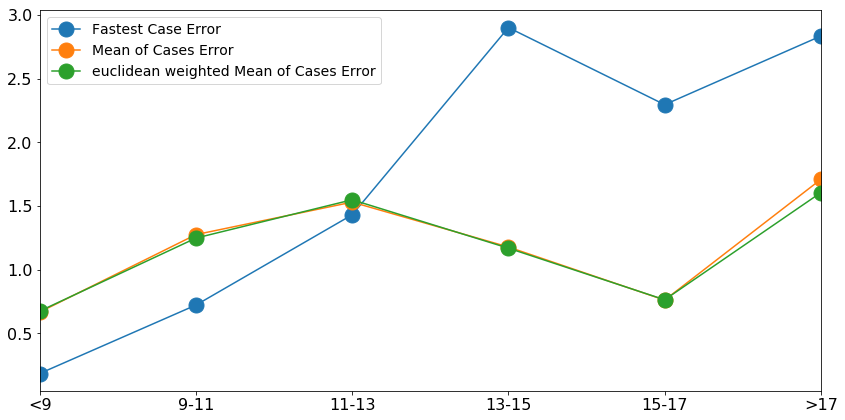

In [345]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra6 = pd.DataFrame({'Mean of Cases Error': mean4, 'Fastest Case Error': best4, 'euclidean weighted Mean of Cases Error': euc4}, index=index)
ax = gra6.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

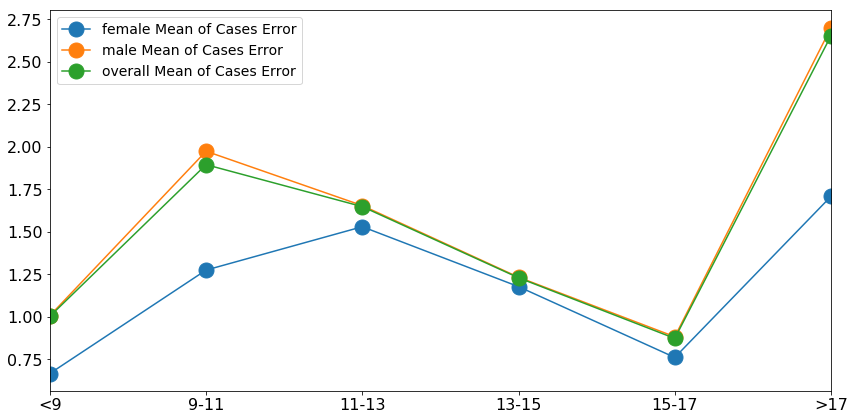

In [346]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra6 = pd.DataFrame({'female Mean of Cases Error': mean4, 'male Mean of Cases Error': mean3, 'overall Mean of Cases Error': mean2}, index=index)
ax = gra6.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

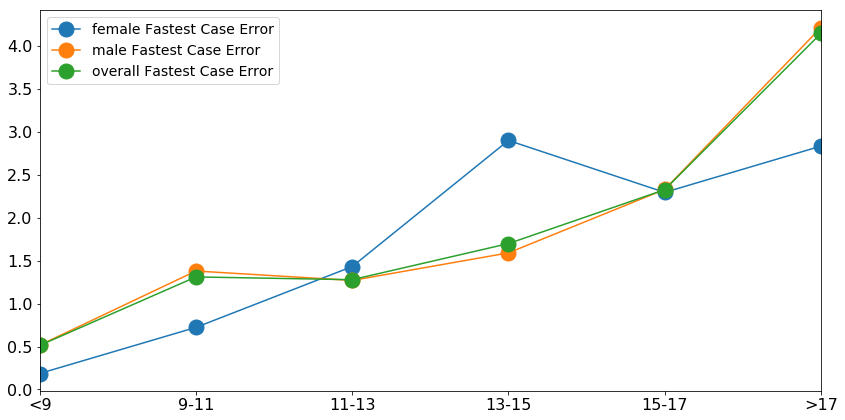

In [347]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra10 = pd.DataFrame({'female Fastest Case Error': best4, 'male Fastest Case Error': best3, 'overall Fastest Case Error': best2}, index=index)
ax = gra10.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

# Males vs Females

In [348]:
mean4 = [femaleg9M, femaleg11M, femaleg13M, femaleg15M, femaleg17M, femaleg19M]
best4 = [femaleg9B, femaleg11B, femaleg13B, femaleg15B, femaleg17B, femaleg19B]
euc4 = [femaleg9E, femaleg11E, femaleg13E, femaleg15E, femaleg17E, femaleg19E]

In [349]:
mean3 = [maleg9M, maleg11M, maleg13M, maleg15M, maleg17M, maleg19M]
best3 = [maleg9B, maleg11B, maleg13B, maleg15B, maleg17B, maleg19B]
euc3 = [maleg9E, maleg11E, maleg13E, maleg15E, maleg17E, maleg19E]

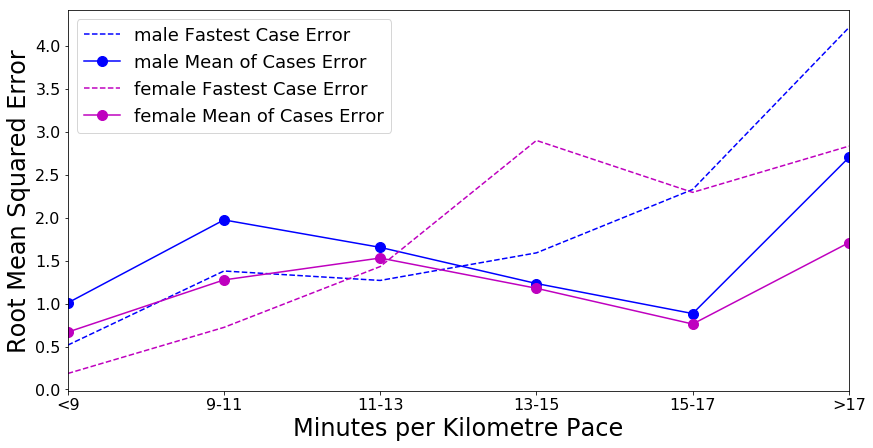

In [350]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra5 = pd.DataFrame({'male Mean of Cases Error': mean3, 'male Fastest Case Error': best3}, index=index)
gra15 = pd.DataFrame({'female Mean of Cases Error': mean4, 'female Fastest Case Error': best4}, index=index)
styles1 = ['b--','bo-']
styles2 = ['m--','mo-']
fig, ax = plt.subplots()
gra5.plot(style=styles1, ax=ax, figsize = (14, 7), fontsize = 16, ms=10)
gra15.plot(style=styles2, ax=ax, figsize = (14, 7), fontsize = 16, ms=10)
ax.set_ylabel('Root Mean Squared Error', fontsize = 24)
ax.set_xlabel('Minutes per Kilometre Pace', fontsize = 24)
ax.legend(fontsize = 18)
#testdataframe2.plot(style=styles2, ax=ax)

In [351]:
mean8 = [fgm9_per, fgm11_per, fgm13_per, fgm15_per, fgm17_per, fgm19_per]
best8 = [fgb9_per, fgb11_per, fgb13_per, fgb15_per, fgb17_per, fgb19_per]

In [352]:
mean9 = [mgm9_per, mgm11_per, mgm13_per, mgm15_per, mgm17_per, mgm19_per]
best9 = [mgb9_per, mgb11_per, mgb13_per, mgb15_per, mgb17_per, mgb19_per]

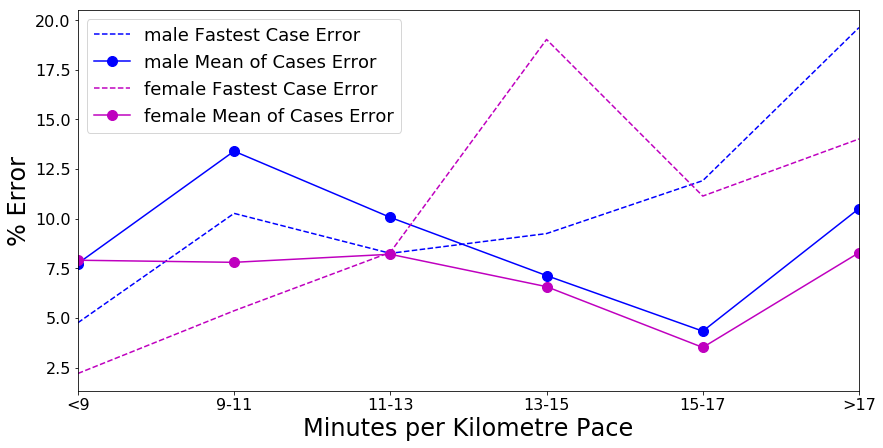

In [353]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra9 = pd.DataFrame({'male Mean of Cases Error': mean9, 'male Fastest Case Error': best9}, index=index)
gra8 = pd.DataFrame({'female Mean of Cases Error': mean8, 'female Fastest Case Error': best8}, index=index)
styles1 = ['b--','bo-']
styles2 = ['m--','mo-']
fig, ax = plt.subplots()
gra9.plot(style=styles1, ax=ax, figsize = (14, 7), fontsize = 16, ms=10)
gra8.plot(style=styles2, ax=ax, figsize = (14, 7), fontsize = 16, ms=10)
ax.set_ylabel('% Error', fontsize = 24)
ax.set_xlabel('Minutes per Kilometre Pace', fontsize = 24)
ax.legend(fontsize = 18)
#testdataframe2.plot(style=styles2, ax=ax)

In [354]:
mean4 = [femaleg9M, femaleg11M, femaleg13M, femaleg15M, femaleg17M, femaleg19M]
best4 = [femaleg9B, femaleg11B, femaleg13B, femaleg15B, femaleg17B, femaleg19B]
euc4 = [femaleg9E, femaleg11E, femaleg13E, femaleg15E, femaleg17E, femaleg19E]

In [355]:
mean3 = [maleg9M, maleg11M, maleg13M, maleg15M, maleg17M, maleg19M]
best3 = [maleg9B, maleg11B, maleg13B, maleg15B, maleg17B, maleg19B]
euc3 = [maleg9E, maleg11E, maleg13E, maleg15E, maleg17E, maleg19E]

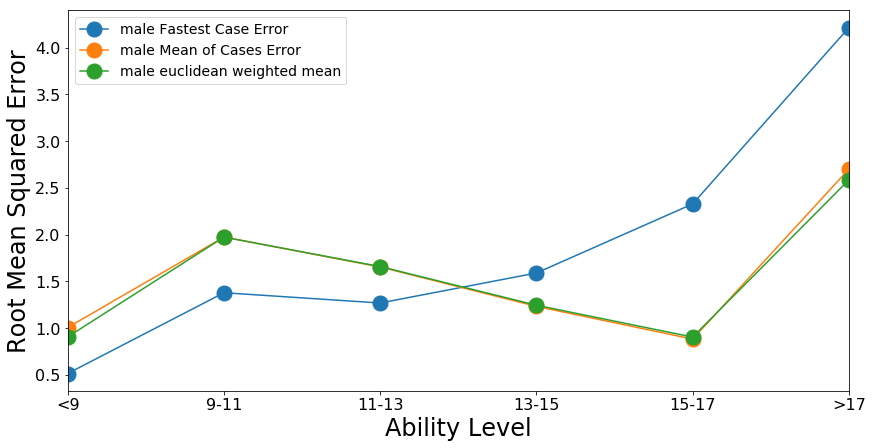

In [356]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra5 = pd.DataFrame({'male Mean of Cases Error': mean3, 'male Fastest Case Error': best3,  'male euclidean weighted mean': euc3}, index=index)
ax = gra5.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.set_ylabel('Root Mean Squared Error', fontsize = 24)
ax.set_xlabel('Ability Level', fontsize = 24)
ax.legend(fontsize = 14)

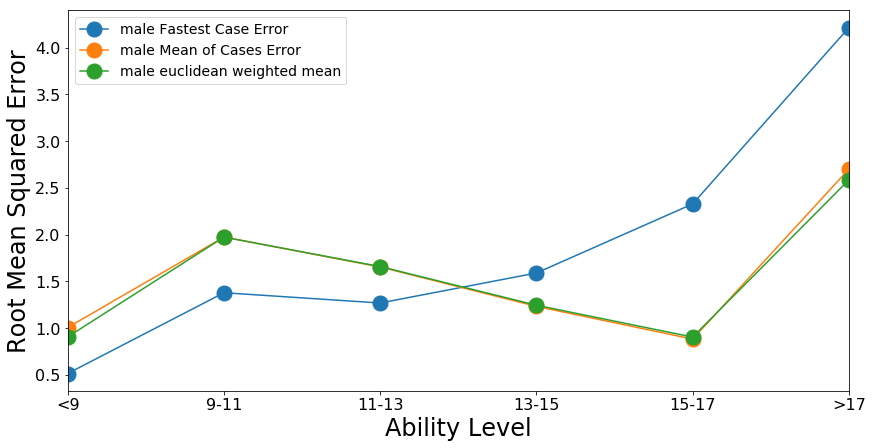

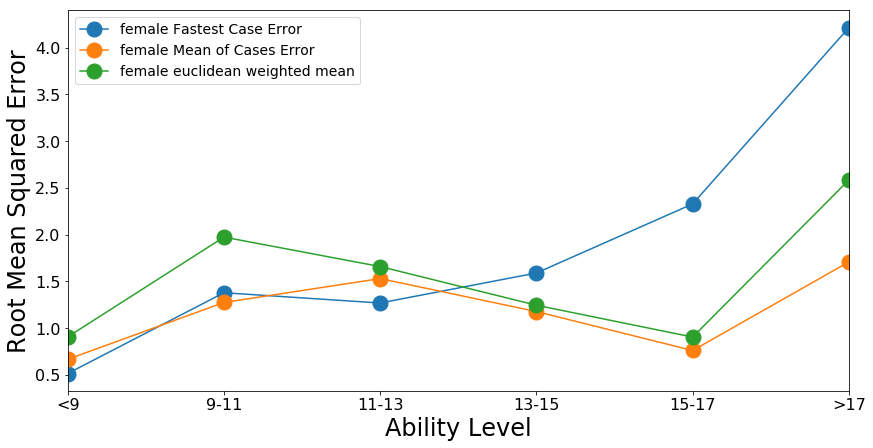

In [357]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra5 = pd.DataFrame({'male Mean of Cases Error': mean3, 'male Fastest Case Error': best3,  'male euclidean weighted mean': euc3}, index=index)
styles = ['bs-','ro-','y^-']
linewidths = [2, 1, 4]
ax = gra5.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.set_ylabel('Root Mean Squared Error', fontsize = 24)
ax.set_xlabel('Ability Level', fontsize = 24)
ax.legend(fontsize = 14)
gra15 = pd.DataFrame({'female Mean of Cases Error': mean4, 'female Fastest Case Error': best3,  'female euclidean weighted mean': euc3}, index=index)
ax1 = gra15.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax1.set_ylabel('Root Mean Squared Error', fontsize = 24)
ax1.set_xlabel('Ability Level', fontsize = 24)
ax1.legend(fontsize = 14)

# Categorical Ability

## Senior Men Ability

In [358]:
sg9 = sen[(sen.query_pb <= 9)]
sg11 = sen[(sen.query_pb > 9) & (sen.query_pb <= 11)]
sg13 = sen[(sen.query_pb > 11) & (sen.query_pb <= 13)]
sg15 = sen[(sen.query_pb > 13) & (sen.query_pb <= 15)]
sg17 = sen[(sen.query_pb > 15) & (sen.query_pb <= 17)]
sg19 = sen[(sen.query_pb > 17)]

### Bin counts

In [359]:
sg9count = sg9.shape[0]
sg11count = sg11.shape[0]
sg13count = sg13.shape[0]
sg15count = sg15.shape[0]
sg17count = sg17.shape[0]
sg19count = sg19.shape[0]

In [360]:
count2 = [sg9count, sg11count, sg13count, sg15count, sg17count, sg19count]

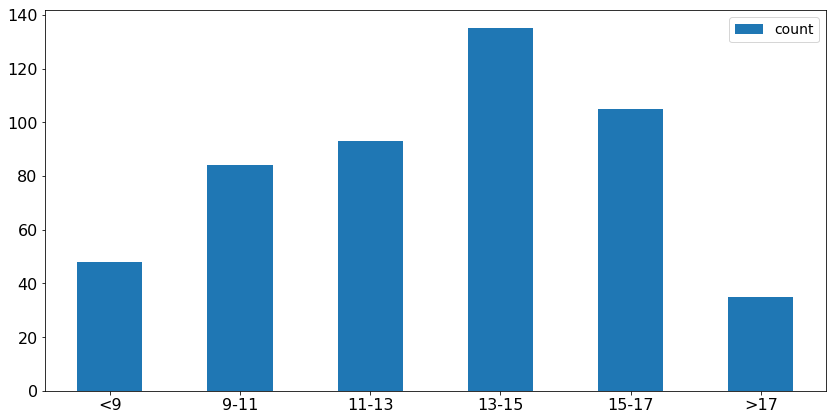

In [361]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count2}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [362]:

sg9B = sqrt(mean_squared_error(sg9.query_pb, sg9.best_pb_prediction))
sg9M = sqrt(mean_squared_error(sg9.query_pb, sg9.mean_pb_average_pace))

sg11B = sqrt(mean_squared_error(sg11.query_pb, sg11.best_pb_prediction))
sg11M = sqrt(mean_squared_error(sg11.query_pb, sg11.mean_pb_average_pace))

sg13B = sqrt(mean_squared_error(sg13.query_pb, sg13.best_pb_prediction))
sg13M = sqrt(mean_squared_error(sg13.query_pb, sg13.mean_pb_average_pace))

sg15B = sqrt(mean_squared_error(sg15.query_pb, sg15.best_pb_prediction))
sg15M = sqrt(mean_squared_error(sg15.query_pb, sg15.mean_pb_average_pace))

sg17B = sqrt(mean_squared_error(sg17.query_pb, sg17.best_pb_prediction))
sg17M = sqrt(mean_squared_error(sg17.query_pb, sg17.mean_pb_average_pace))

sg19B = sqrt(mean_squared_error(sg19.query_pb, sg19.best_pb_prediction))
sg19M = sqrt(mean_squared_error(sg19.query_pb, sg19.mean_pb_average_pace))


print('Sen U9 Fastest Case Error:', sg9B)
print('Sen U9 Mean of Cases Error:', sg9M)
print('Sen 9-11 Fastest Case Error:', sg11B)
print('Sen 9-11 Mean of Cases Error:', sg11M)
print('Sen 11-13 Fastest Case Error:', sg13B)
print('Sen 11-13 Mean of Cases Error:', sg13M)
print('Sen 13-15 Fastest Case Error:', sg15B)
print('Sen 13-15 Mean of Cases Error:', sg15M)
print('Sen 15-17 Fastest Case Error:', sg17B)
print('Sen 15-17 Mean of Cases Error:', sg17M)
print('Sen O17 Fastest Case Error:', sg19B)
print('Sen 017 Mean of Cases Error:', sg19M)

Sen U9 Fastest Case Error: 0.5073787624683734
Sen U9 Mean of Cases Error: 1.1134815065529546
Sen 9-11 Fastest Case Error: 1.4840198319773967
Sen 9-11 Mean of Cases Error: 2.0939280138318868
Sen 11-13 Fastest Case Error: 1.4623812647449856
Sen 11-13 Mean of Cases Error: 1.8185597108256204
Sen 13-15 Fastest Case Error: 1.7023314016639592
Sen 13-15 Mean of Cases Error: 1.300090906685738
Sen 15-17 Fastest Case Error: 2.1445237104293144
Sen 15-17 Mean of Cases Error: 0.9071416040974705
Sen O17 Fastest Case Error: 4.179184616065072
Sen 017 Mean of Cases Error: 2.4150383599291803


In [363]:
mean5 = [sg9M, sg11M, sg13M, sg15M, sg17M, sg19M]
best5 = [sg9B, sg11B, sg13B, sg15B, sg17B, sg19B]

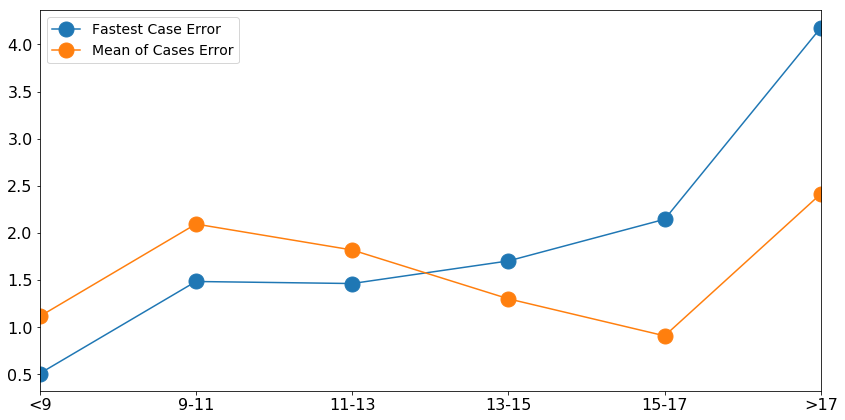

In [364]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra12 = pd.DataFrame({'Mean of Cases Error': mean5, 'Fastest Case Error': best5}, index=index)
ax = gra12.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

## Masters Men 1 Ability

In [365]:
mg9 = mas[(mas.query_pb <= 9)]
mg11 = mas[(mas.query_pb > 9) & (mas.query_pb <= 11)]
mg13 = mas[(mas.query_pb > 11) & (mas.query_pb <= 13)]
mg15 = mas[(mas.query_pb > 13) & (mas.query_pb <= 15)]
mg17 = mas[(mas.query_pb > 15) & (mas.query_pb <= 17)]
mg19 = mas[(mas.query_pb > 17)]

### Bin counts

In [366]:
mg9count = mg9.shape[0]
mg11count = mg11.shape[0]
mg13count = mg13.shape[0]
mg15count = mg15.shape[0]
mg17count = mg17.shape[0]
mg19count = mg19.shape[0]

In [367]:
count3 = [mg9count, mg11count, mg13count, mg15count, mg17count, mg19count]

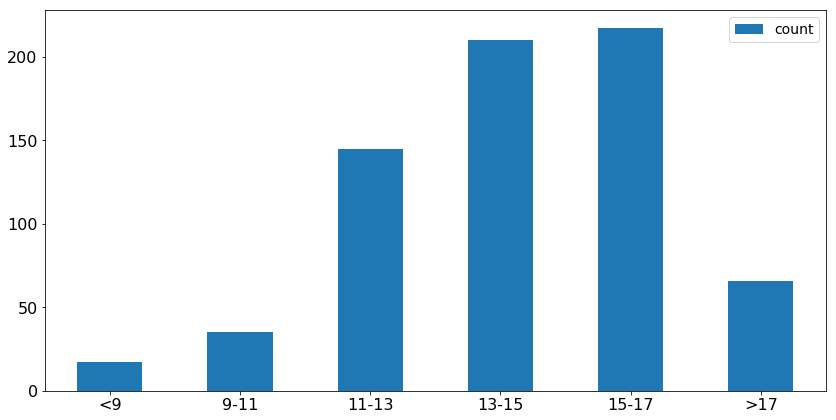

In [368]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count3}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [369]:


mg9B = sqrt(mean_squared_error(mg9.query_pb, mg9.best_pb_prediction))
mg9M = sqrt(mean_squared_error(mg9.query_pb, mg9.mean_pb_average_pace))

mg11B = sqrt(mean_squared_error(mg11.query_pb, mg11.best_pb_prediction))
mg11M = sqrt(mean_squared_error(mg11.query_pb, mg11.mean_pb_average_pace))

mg13B = sqrt(mean_squared_error(mg13.query_pb, mg13.best_pb_prediction))
mg13M = sqrt(mean_squared_error(mg13.query_pb, mg13.mean_pb_average_pace))

mg15B = sqrt(mean_squared_error(mg15.query_pb, mg15.best_pb_prediction))
mg15M = sqrt(mean_squared_error(mg15.query_pb, mg15.mean_pb_average_pace))

mg17B = sqrt(mean_squared_error(mg17.query_pb, mg17.best_pb_prediction))
mg17M = sqrt(mean_squared_error(mg17.query_pb, mg17.mean_pb_average_pace))

mg19B = sqrt(mean_squared_error(mg19.query_pb, mg19.best_pb_prediction))
mg19M = sqrt(mean_squared_error(mg19.query_pb, mg19.mean_pb_average_pace))


print('Mas U9 Fastest Case Error:', mg9B)
print('Mas U9 Mean of Cases Error:', mg9M)
print('Mas 9-11 Fastest Case Error:', mg11B)
print('Mas 9-11 Mean of Cases Error:', mg11M)
print('Mas 11-13 Fastest Case Error:', mg13B)
print('Mas 11-13 Mean of Cases Error:', mg13M)
print('Mas 13-15 Fastest Case Error:', mg15B)
print('Mas 13-15 Mean of Cases Error:', mg15M)
print('Mas 15-17 Fastest Case Error:', mg17B)
print('Mas 15-17 Mean of Cases Error:', mg17M)
print('Mas O17 Fastest Case Error:', mg19B)
print('Mas 017 Mean of Cases Error:', mg19M)

Mas U9 Fastest Case Error: 0.5285771064957514
Mas U9 Mean of Cases Error: 0.7014732581023931
Mas 9-11 Fastest Case Error: 1.0504512674919861
Mas 9-11 Mean of Cases Error: 1.4850143833915639
Mas 11-13 Fastest Case Error: 1.2040830196303507
Mas 11-13 Mean of Cases Error: 1.6040777189167252
Mas 13-15 Fastest Case Error: 1.5918462031681693
Mas 13-15 Mean of Cases Error: 1.2302514913366456
Mas 15-17 Fastest Case Error: 2.40083906627006
Mas 15-17 Mean of Cases Error: 0.852859515763586
Mas O17 Fastest Case Error: 3.540759280740889
Mas 017 Mean of Cases Error: 2.230398247205954


In [370]:
mean6 = [mg9M, mg11M, mg13M, mg15M, mg17M, mg19M]
best6 = [mg9B, mg11B, mg13B, mg15B, mg17B, mg19B]

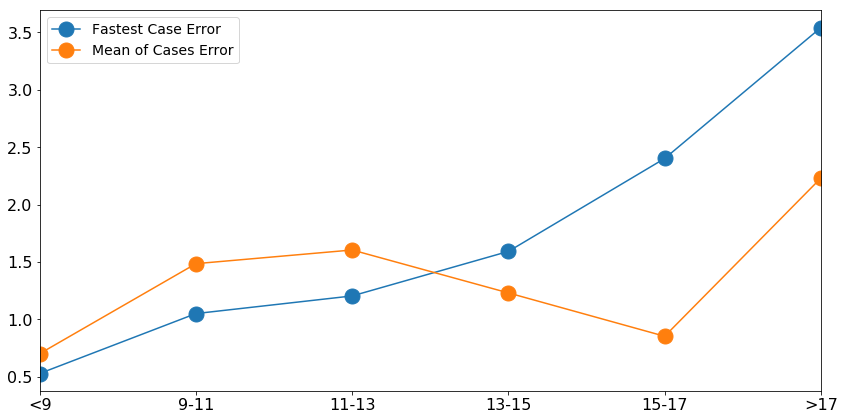

In [371]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra13 = pd.DataFrame({'Mean of Cases Error': mean6, 'Fastest Case Error': best6}, index=index)
ax = gra13.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

## Masters Men 2 Ability

In [372]:
m2g9 = mas2[(mas2.query_pb <= 9)]
m2g11 = mas2[(mas2.query_pb > 9) & (mas2.query_pb <= 11)]
m2g13 = mas2[(mas2.query_pb > 11) & (mas2.query_pb <= 13)]
m2g15 = mas2[(mas2.query_pb > 13) & (mas2.query_pb <= 15)]
m2g17 = mas2[(mas2.query_pb > 15) & (mas2.query_pb <= 17)]
m2g19 = mas2[(mas2.query_pb > 17)]

### Bin counts

In [373]:
m2g9count = m2g9.shape[0]
m2g11count = m2g11.shape[0]
m2g13count = m2g13.shape[0]
m2g15count = m2g15.shape[0]
m2g17count = m2g17.shape[0]
m2g19count = m2g19.shape[0]

In [374]:
count3 = [m2g9count, m2g11count, m2g13count, m2g15count, m2g17count, m2g19count]

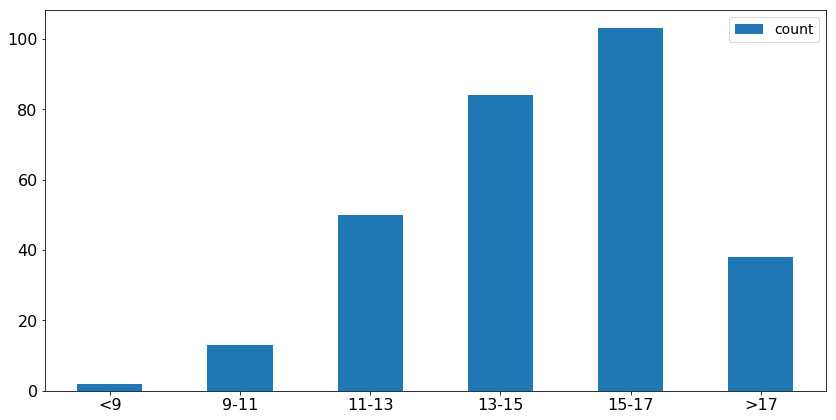

In [375]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count3}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [376]:

m2g9B = sqrt(mean_squared_error(m2g9.query_pb, m2g9.best_pb_prediction))
m2g9M = sqrt(mean_squared_error(m2g9.query_pb, m2g9.mean_pb_average_pace))

m2g11B = sqrt(mean_squared_error(m2g11.query_pb, m2g11.best_pb_prediction))
m2g11M = sqrt(mean_squared_error(m2g11.query_pb, m2g11.mean_pb_average_pace))

m2g13B = sqrt(mean_squared_error(m2g13.query_pb, m2g13.best_pb_prediction))
m2g13M = sqrt(mean_squared_error(m2g13.query_pb, m2g13.mean_pb_average_pace))

m2g15B = sqrt(mean_squared_error(m2g15.query_pb, m2g15.best_pb_prediction))
m2g15M = sqrt(mean_squared_error(m2g15.query_pb, m2g15.mean_pb_average_pace))

m2g17B = sqrt(mean_squared_error(m2g17.query_pb, m2g17.best_pb_prediction))
m2g17M = sqrt(mean_squared_error(m2g17.query_pb, m2g17.mean_pb_average_pace))

m2g19B = sqrt(mean_squared_error(m2g19.query_pb, m2g19.best_pb_prediction))
m2g19M = sqrt(mean_squared_error(m2g19.query_pb, m2g19.mean_pb_average_pace))


print('Mas2 U9 Fastest Case Error:', m2g9B)
print('Mas2 U9 Mean of Cases Error:', m2g9M)
print('Mas2 9-11 Fastest Case Error:', m2g11B)
print('Mas2 9-11 Mean of Cases Error:', m2g11M)
print('Mas2 11-13 Fastest Case Error:', m2g13B)
print('Mas2 11-13 Mean of Cases Error:', m2g13M)
print('Mas2 13-15 Fastest Case Error:', m2g15B)
print('Mas2 13-15 Mean of Cases Error:', m2g15M)
print('Mas2 15-17 Fastest Case Error:', m2g17B)
print('Mas2 15-17 Mean of Cases Error:', m2g17M)
print('Mas2 O17 Fastest Case Error:', m2g19B)
print('Mas2 017 Mean of Cases Error:', m2g19M)

Mas2 U9 Fastest Case Error: 0.4557850696426905
Mas2 U9 Mean of Cases Error: 0.2862829845887258
Mas2 9-11 Fastest Case Error: 1.0167309860735367
Mas2 9-11 Mean of Cases Error: 1.4584406100099803
Mas2 11-13 Fastest Case Error: 1.0909573724213235
Mas2 11-13 Mean of Cases Error: 1.583728790706527
Mas2 13-15 Fastest Case Error: 1.4000479288924672
Mas2 13-15 Mean of Cases Error: 1.1590293202500923
Mas2 15-17 Fastest Case Error: 2.4301456054153068
Mas2 15-17 Mean of Cases Error: 0.9393695192071311
Mas2 O17 Fastest Case Error: 5.302646721316251
Mas2 017 Mean of Cases Error: 3.652952989864701


In [377]:
mean7 = [m2g9M, m2g11M, m2g13M, m2g15M, m2g17M, m2g19M]
best7 = [m2g9B, m2g11B, m2g13B, m2g15B, m2g17B, m2g19B]

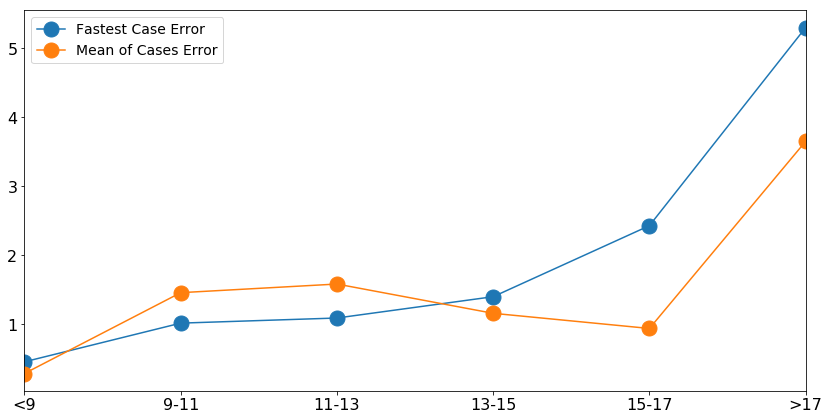

In [378]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra14 = pd.DataFrame({'Mean of Cases Error': mean7, 'Fastest Case Error': best7}, index=index)
ax = gra14.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

## Masters Men 3 Ability

In [379]:
m3g9 = mas3[(mas3.query_pb <= 9)]
m3g11 = mas3[(mas3.query_pb > 9) & (mas3.query_pb <= 11)]
m3g13 = mas3[(mas3.query_pb > 11) & (mas3.query_pb <= 13)]
m3g15 = mas3[(mas3.query_pb > 13) & (mas3.query_pb <= 15)]
m3g17 = mas3[(mas3.query_pb > 15) & (mas3.query_pb <= 17)]
m3g19 = mas3[(mas3.query_pb > 17)]

### Bin counts

In [380]:
m3g9count = m3g9.shape[0]
m3g11count = m3g11.shape[0]
m3g13count = m3g13.shape[0]
m3g15count = m3g15.shape[0]
m3g17count = m3g17.shape[0]
m3g19count = m3g19.shape[0]

In [381]:
count4 = [m3g9count, m3g11count, m3g13count, m3g15count, m3g17count, m3g19count]

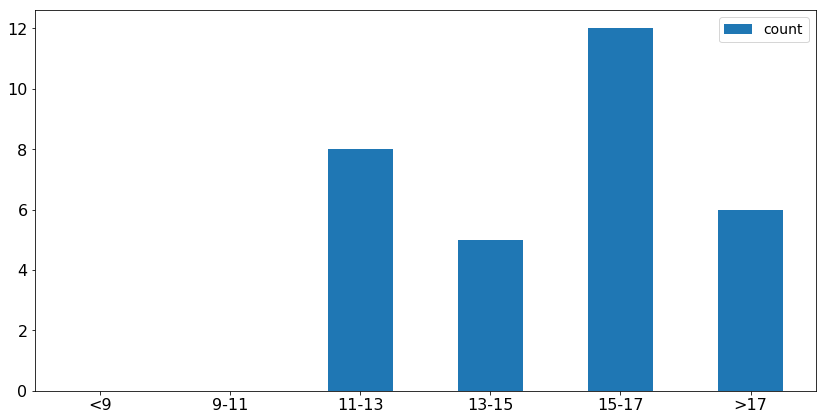

In [382]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count4}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [383]:


#m3g9B = sqrt(mean_squared_error(m3g9.query_pb, m3g9.best_pb_prediction))
#m3g9M = sqrt(mean_squared_error(m3g9.query_pb, m3g9.mean_pb_average_pace))

#m3g11B = sqrt(mean_squared_error(m3g11.query_pb, m3g11.best_pb_prediction))
#m3g11M = sqrt(mean_squared_error(m3g11.query_pb, m3g11.mean_pb_average_pace))

m3g13B = sqrt(mean_squared_error(m3g13.query_pb, m3g13.best_pb_prediction))
m3g13M = sqrt(mean_squared_error(m3g13.query_pb, m3g13.mean_pb_average_pace))

m3g15B = sqrt(mean_squared_error(m3g15.query_pb, m3g15.best_pb_prediction))
m3g15M = sqrt(mean_squared_error(m3g15.query_pb, m3g15.mean_pb_average_pace))

m3g17B = sqrt(mean_squared_error(m3g17.query_pb, m3g17.best_pb_prediction))
m3g17M = sqrt(mean_squared_error(m3g17.query_pb, m3g17.mean_pb_average_pace))

#m3g19B = sqrt(mean_squared_error(m3g19.query_pb, m3g19.best_pb_prediction))
#m3g19M = sqrt(mean_squared_error(m3g19.query_pb, m3g19.mean_pb_average_pace))


#print('Mas3 U9 Fastest Case Error:', m3g9B)
#print('Mas3 U9 Mean of Cases Error:', m3g9M)
#print('Mas3 9-11 Fastest Case Error:', m3g11B)
#print('Mas3 9-11 Mean of Cases Error:', m3g11M)
print('Mas3 11-13 Fastest Case Error:', m3g13B)
print('Mas3 11-13 Mean of Cases Error:', m3g13M)
print('Mas3 13-15 Fastest Case Error:', m3g15B)
print('Mas3 13-15 Mean of Cases Error:', m3g15M)
print('Mas3 15-17 Fastest Case Error:', m3g17B)
print('Mas3 15-17 Mean of Cases Error:', m3g17M)
#print('Mas3 O17 Fastest Case Error:', m3g19B)
#print('Mas3 017 Mean of Cases Error:', m3g19M)

Mas3 11-13 Fastest Case Error: 1.0814777481980684
Mas3 11-13 Mean of Cases Error: 0.9266963575128903
Mas3 13-15 Fastest Case Error: 1.5038220156875535
Mas3 13-15 Mean of Cases Error: 0.7136172463630781
Mas3 15-17 Fastest Case Error: 1.5110534947569199
Mas3 15-17 Mean of Cases Error: 0.7070851148006344


In [384]:
mean8 = [m3g13M, m3g15M, m3g17M]
best8 = [m3g13B, m3g15B, m3g17B]

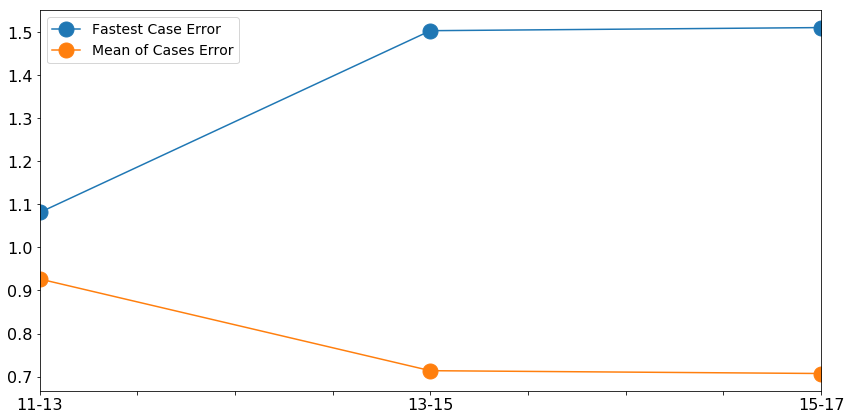

In [385]:
index = ['11-13', '13-15', '15-17']
gra15 = pd.DataFrame({'Mean of Cases Error': mean8, 'Fastest Case Error': best8}, index=index)
ax = gra15.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

## Masters Women 1 Ability

In [386]:
w1g9 = wom1[(wom1.query_pb <= 9)]
w1g11 = wom1[(wom1.query_pb > 9) & (wom1.query_pb <= 11)]
w1g13 = wom1[(wom1.query_pb > 11) & (wom1.query_pb <= 13)]
w1g15 = wom1[(wom1.query_pb > 13) & (wom1.query_pb <= 15)]
w1g17 = wom1[(wom1.query_pb > 15) & (wom1.query_pb <= 17)]
w1g19 = wom1[(wom1.query_pb > 17)]

### Bin counts

In [387]:
w1g9count = w1g9.shape[0]
w1g11count = w1g11.shape[0]
w1g13count = w1g13.shape[0]
w1g15count = w1g15.shape[0]
w1g17count = w1g17.shape[0]
w1g19count = w1g19.shape[0]

In [388]:
count5 = [w1g9count, w1g11count, w1g13count, w1g15count, w1g17count, w1g19count]

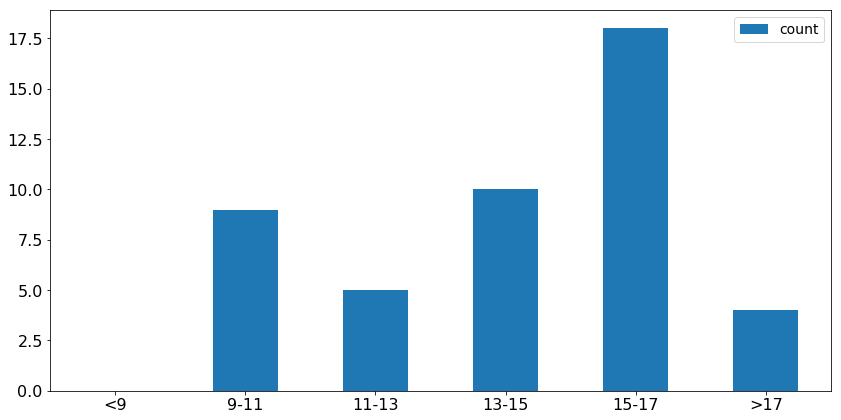

In [389]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count5}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [390]:

# w1g9B = sqrt(mean_squared_error(w1g9.query_pb, w1g9.best_pb_prediction))
# w1g9M = sqrt(mean_squared_error(w1g9.query_pb, w1g9.mean_pb_average_pace))

w1g11B = sqrt(mean_squared_error(w1g11.query_pb, w1g11.best_pb_prediction))
w1g11M = sqrt(mean_squared_error(w1g11.query_pb, w1g11.mean_pb_average_pace))

w1g13B = sqrt(mean_squared_error(w1g13.query_pb, w1g13.best_pb_prediction))
w1g13M = sqrt(mean_squared_error(w1g13.query_pb, w1g13.mean_pb_average_pace))

w1g15B = sqrt(mean_squared_error(w1g15.query_pb, w1g15.best_pb_prediction))
w1g15M = sqrt(mean_squared_error(w1g15.query_pb, w1g15.mean_pb_average_pace))

w1g17B = sqrt(mean_squared_error(w1g17.query_pb, w1g17.best_pb_prediction))
w1g17M = sqrt(mean_squared_error(w1g17.query_pb, w1g17.mean_pb_average_pace))

w1g19B = sqrt(mean_squared_error(w1g19.query_pb, w1g19.best_pb_prediction))
w1g19M = sqrt(mean_squared_error(w1g19.query_pb, w1g19.mean_pb_average_pace))


# print('Wom1 U9 Fastest Case Error:', w1g9B)
# print('Wom1 U9 Mean of Cases Error:', w1g9M)
print('Wom1 9-11 Fastest Case Error:', w1g11B)
print('Wom1 9-11 Mean of Cases Error:', w1g11M)
print('Wom1 11-13 Fastest Case Error:', w1g13B)
print('Wom1 11-13 Mean of Cases Error:', w1g13M)
print('Wom1 13-15 Fastest Case Error:', w1g15B)
print('Wom1 13-15 Mean of Cases Error:', w1g15M)
print('Wom1 15-17 Fastest Case Error:', w1g17B)
print('Wom1 15-17 Mean of Cases Error:', w1g17M)
print('Wom1 O17 Fastest Case Error:', w1g19B)
print('Wom1 017 Mean of Cases Error:', w1g19M)

Wom1 9-11 Fastest Case Error: 0.43390361873416955
Wom1 9-11 Mean of Cases Error: 0.3896546972444702
Wom1 11-13 Fastest Case Error: 1.553309057572958
Wom1 11-13 Mean of Cases Error: 1.3910694201018987
Wom1 13-15 Fastest Case Error: 2.609883379378091
Wom1 13-15 Mean of Cases Error: 1.3677053092196938
Wom1 15-17 Fastest Case Error: 2.348513924639572
Wom1 15-17 Mean of Cases Error: 0.697002561619656
Wom1 O17 Fastest Case Error: 3.080039103809216
Wom1 017 Mean of Cases Error: 1.3566046322153207


In [391]:
mean9 = [ w1g11M, w1g13M, w1g15M, w1g17M, w1g19M]
best9 = [ w1g11B, w1g13B, w1g15B, w1g17B, w1g19B]

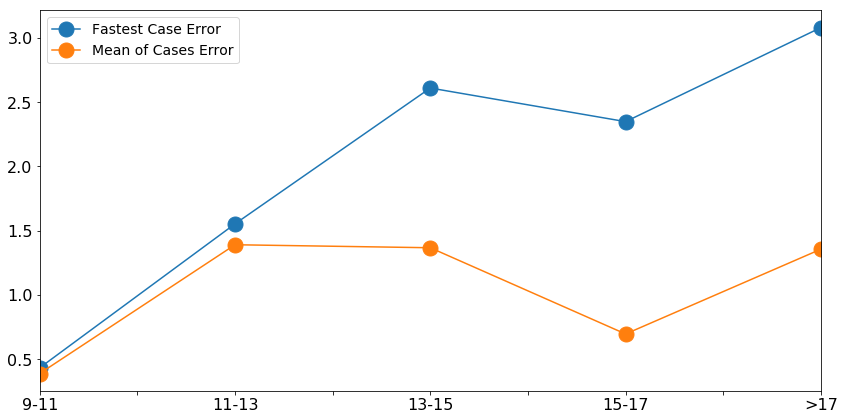

In [392]:
index = [ '9-11', '11-13', '13-15', '15-17', '>17']
gra16 = pd.DataFrame({'Mean of Cases Error': mean9, 'Fastest Case Error': best9}, index=index)
ax = gra16.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

## Masters Women 2 Ability

In [393]:
w2g9 = wom2[(wom2.query_pb <= 9)]
w2g11 = wom2[(wom2.query_pb > 9) & (wom2.query_pb <= 11)]
w2g13 = wom2[(wom2.query_pb > 11) & (wom2.query_pb <= 13)]
w2g15 = wom2[(wom2.query_pb > 13) & (wom2.query_pb <= 15)]
w2g17 = wom2[(wom2.query_pb > 15) & (wom2.query_pb <= 17)]
w2g19 = wom2[(wom2.query_pb > 17)]

### Bin counts

In [394]:
w2g9count = w2g9.shape[0]
w2g11count = w2g11.shape[0]
w2g13count = w2g13.shape[0]
w2g15count = w2g15.shape[0]
w2g17count = w2g17.shape[0]
w2g19count = w2g19.shape[0]

In [395]:
count6 = [w2g9count, w2g11count, w2g13count, w2g15count, w2g17count, w2g19count]

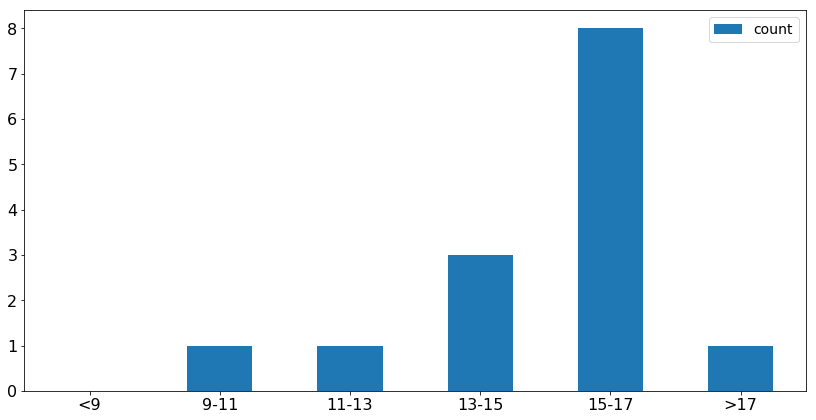

In [396]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count6}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [397]:


#w2g9B = sqrt(mean_squared_error(w2g9.query_pb, w2g9.best_pb_prediction))
#w2g9M = sqrt(mean_squared_error(w2g9.query_pb, w2g9.mean_pb_average_pace))

w2g11B = sqrt(mean_squared_error(w2g11.query_pb, w2g11.best_pb_prediction))
w2g11M = sqrt(mean_squared_error(w2g11.query_pb, w2g11.mean_pb_average_pace))

w2g13B = sqrt(mean_squared_error(w2g13.query_pb, w2g13.best_pb_prediction))
w2g13M = sqrt(mean_squared_error(w2g13.query_pb, w2g13.mean_pb_average_pace))

w2g15B = sqrt(mean_squared_error(w2g15.query_pb, w2g15.best_pb_prediction))
w2g15M = sqrt(mean_squared_error(w2g15.query_pb, w2g15.mean_pb_average_pace))

w2g17B = sqrt(mean_squared_error(w2g17.query_pb, w2g17.best_pb_prediction))
w2g17M = sqrt(mean_squared_error(w2g17.query_pb, w2g17.mean_pb_average_pace))

w2g19B = sqrt(mean_squared_error(w2g19.query_pb, w2g19.best_pb_prediction))
w2g19M = sqrt(mean_squared_error(w2g19.query_pb, w2g19.mean_pb_average_pace))


#print('Wom2 U9 Fastest Case Error:', w2g9B)
#print('Wom2 U9 Mean of Cases Error:', w2g9M)
print('Wom2 9-11 Fastest Case Error:', w2g11B)
print('Wom2 9-11 Mean of Cases Error:', w2g11M)
print('Wom2 11-13 Fastest Case Error:', w2g13B)
print('Wom2 11-13 Mean of Cases Error:', w2g13M)
print('Wom2 13-15 Fastest Case Error:', w2g15B)
print('Wom2 13-15 Mean of Cases Error:', w2g15M)
print('Wom2 15-17 Fastest Case Error:', w2g17B)
print('Wom2 15-17 Mean of Cases Error:', w2g17M)
print('Wom2 O17 Fastest Case Error:', w2g19B)
print('Wom2 017 Mean of Cases Error:', w2g19M)

Wom2 9-11 Fastest Case Error: 0.8643872676622681
Wom2 9-11 Mean of Cases Error: 0.459532542136019
Wom2 11-13 Fastest Case Error: 3.215133188097923
Wom2 11-13 Mean of Cases Error: 3.8659058938075344
Wom2 13-15 Fastest Case Error: 3.551965287213073
Wom2 13-15 Mean of Cases Error: 0.2688830049655132
Wom2 15-17 Fastest Case Error: 1.6415739334994006
Wom2 15-17 Mean of Cases Error: 0.5836401819010022
Wom2 O17 Fastest Case Error: 3.615846566150214
Wom2 017 Mean of Cases Error: 3.0856796704724623


In [398]:
mean10 = [w2g11M, w2g13M, w2g15M, w2g17M, w2g19M]
best10 = [w2g11B, w2g13B, w2g15B, w2g17B, w2g19B]

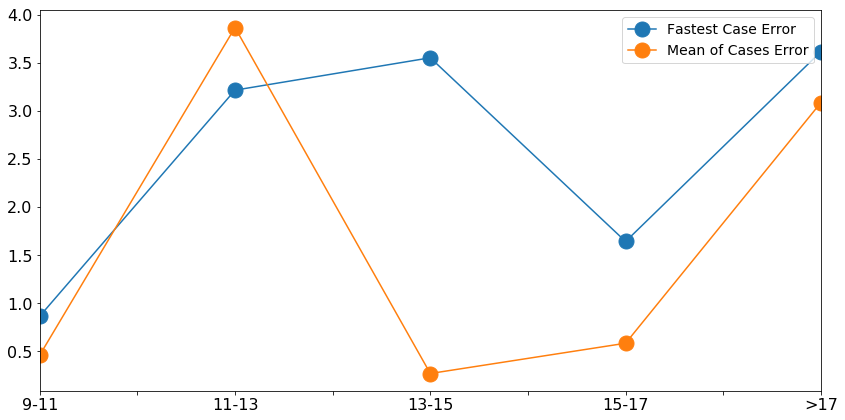

In [399]:
index = ['9-11', '11-13','13-15', '15-17', '>17']
gra18 = pd.DataFrame({'Mean of Cases Error': mean10, 'Fastest Case Error': best10}, index=index)
ax = gra18.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

## Senior Women Ability

In [400]:
sw9 = senW[(senW.query_pb <= 9)]
sw11 = senW[(senW.query_pb > 9) & (senW.query_pb <= 11)]
sw13 = senW[(senW.query_pb > 11) & (senW.query_pb <= 13)]
sw15 = senW[(senW.query_pb > 13) & (senW.query_pb <= 15)]
sw17 = senW[(senW.query_pb > 15) & (senW.query_pb <= 17)]
sw19 = senW[(senW.query_pb > 17)]

### Bin counts

In [401]:
sw9count = sw9.shape[0]
sw11count = sw11.shape[0]
sw13count = sw13.shape[0]
sw15count = sw15.shape[0]
sw17count = sw17.shape[0]
sw19count = sw19.shape[0]

In [402]:
count7 = [sw9count, sw11count, sw13count, sw15count, sw17count, sw19count]

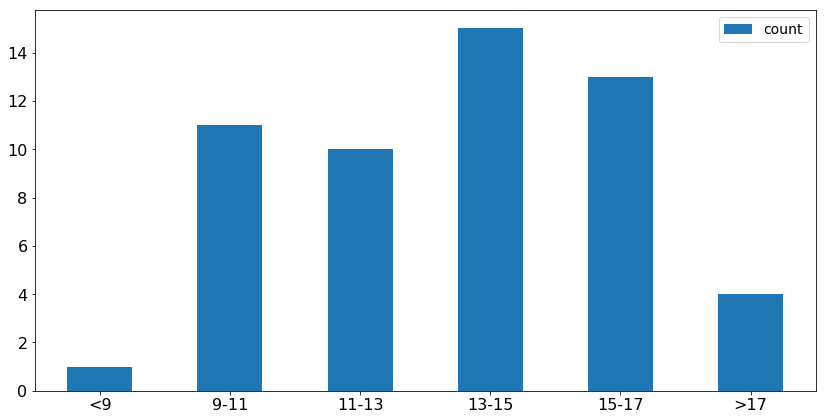

In [403]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count7}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [404]:

sw9B = sqrt(mean_squared_error(sw9.query_pb, sw9.best_pb_prediction))
sw9M = sqrt(mean_squared_error(sw9.query_pb, sw9.mean_pb_average_pace))

sw11B = sqrt(mean_squared_error(sw11.query_pb, sw11.best_pb_prediction))
sw11M = sqrt(mean_squared_error(sw11.query_pb, sw11.mean_pb_average_pace))

sw13B = sqrt(mean_squared_error(sw13.query_pb, sw13.best_pb_prediction))
sw13M = sqrt(mean_squared_error(sw13.query_pb, sw13.mean_pb_average_pace))

sw15B = sqrt(mean_squared_error(sw15.query_pb, sw15.best_pb_prediction))
sw15M = sqrt(mean_squared_error(sw15.query_pb, sw15.mean_pb_average_pace))

sw17B = sqrt(mean_squared_error(sw17.query_pb, sw17.best_pb_prediction))
sw17M = sqrt(mean_squared_error(sw17.query_pb, sw17.mean_pb_average_pace))

sw19B = sqrt(mean_squared_error(sw19.query_pb, sw19.best_pb_prediction))
sw19M = sqrt(mean_squared_error(sw19.query_pb, sw19.mean_pb_average_pace))


print('Senior Women U9 Fastest Case Error:', sw9B)
print('Senior Women U9 Mean of Cases Error:', sw9M)
print('Senior Women 9-11 Fastest Case Error:', sw11B)
print('Senior Women 9-11 Mean of Cases Error:', sw11M)
print('Senior Women 11-13 Fastest Case Error:', sw13B)
print('Senior Women 11-13 Mean of Cases Error:', sw13M)
print('Senior Women 13-15 Fastest Case Error:', sw15B)
print('Senior Women 13-15 Mean of Cases Error:', sw15M)
print('Senior Women 15-17 Fastest Case Error:', sw17B)
print('Senior Women 15-17 Mean of Cases Error:', sw17M)
print('Senior Women O17 Fastest Case Error:', sw19B)
print('Senior Women 017 Mean of Cases Error:', sw19M)

Senior Women U9 Fastest Case Error: 0.1855666905693507
Senior Women U9 Mean of Cases Error: 0.667342649448452
Senior Women 9-11 Fastest Case Error: 0.8801175049772744
Senior Women 9-11 Mean of Cases Error: 1.720910996733589
Senior Women 11-13 Fastest Case Error: 1.017444599657356
Senior Women 11-13 Mean of Cases Error: 1.1333654931397708
Senior Women 13-15 Fastest Case Error: 2.937639744121583
Senior Women 13-15 Mean of Cases Error: 1.1526871612999763
Senior Women 15-17 Fastest Case Error: 2.5080311750377877
Senior Women 15-17 Mean of Cases Error: 0.9274453025782559
Senior Women O17 Fastest Case Error: 2.3034787870462847
Senior Women 017 Mean of Cases Error: 1.5329546797145808


In [405]:
mean11 = [sw9M, sw11M, sw13M, sw15M, sw17M, sw19M]
best11 = [sw9B, sw11B, sw13B, sw15B, sw17B, sw19B]

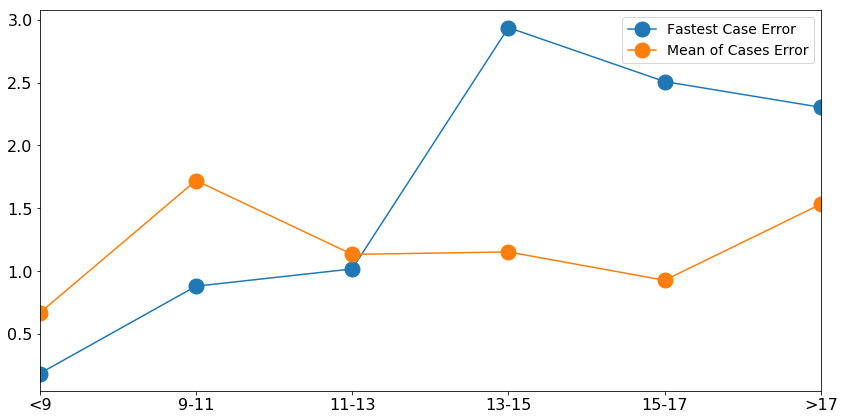

In [406]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
gra18 = pd.DataFrame({'Mean of Cases Error': mean11, 'Fastest Case Error': best11}, index=index)
ax = gra18.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

## Youth Men Ability

In [407]:
you9 = you[(you.query_pb <= 9)]
you11 = you[(you.query_pb > 9) & (you.query_pb <= 11)]
you13 = you[(you.query_pb > 11) & (you.query_pb <= 13)]
you15 = you[(you.query_pb > 13) & (you.query_pb <= 15)]
you17 = you[(you.query_pb > 15) & (you.query_pb <= 17)]
you19 = you[(you.query_pb > 17)]

### Bin counts

In [408]:
you9count = you9.shape[0]
you11count = you11.shape[0]
you13count = you13.shape[0]
you15count = you15.shape[0]
you17count = you17.shape[0]
you19count = you19.shape[0]

In [409]:
count8 = [you9count, you11count, you13count, you15count, you17count, you19count]

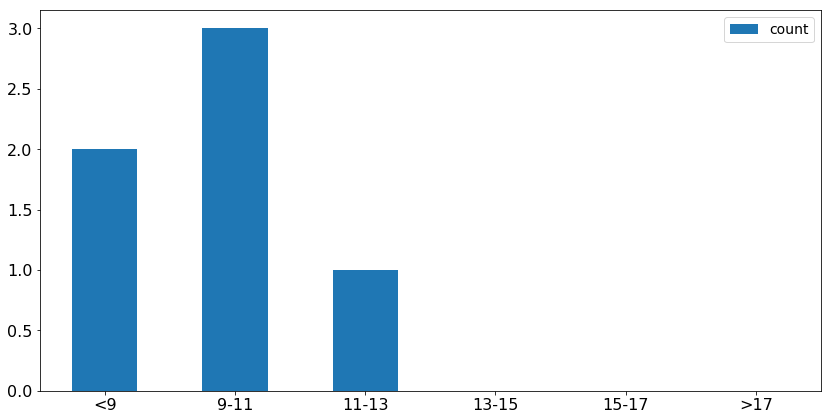

In [410]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count8}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [411]:

you9B = sqrt(mean_squared_error(you9.query_pb, you9.best_pb_prediction))
you9M = sqrt(mean_squared_error(you9.query_pb, you9.mean_pb_average_pace))

you11B = sqrt(mean_squared_error(you11.query_pb, you11.best_pb_prediction))
you11M = sqrt(mean_squared_error(you11.query_pb, you11.mean_pb_average_pace))

you13B = sqrt(mean_squared_error(you13.query_pb, you13.best_pb_prediction))
you13M = sqrt(mean_squared_error(you13.query_pb, you13.mean_pb_average_pace))

#you15B = sqrt(mean_squared_error(you15.query_pb, you15.best_pb_prediction))
#you15M = sqrt(mean_squared_error(you15.query_pb, you15.mean_pb_average_pace))

#you17B = sqrt(mean_squared_error(you17.query_pb, you17.best_pb_prediction))
#you17M = sqrt(mean_squared_error(you17.query_pb, you17.mean_pb_average_pace))

#you19B = sqrt(mean_squared_error(you19.query_pb, you19.best_pb_prediction))
#you19M = sqrt(mean_squared_error(you19.query_pb, you19.mean_pb_average_pace))


print('Youth Men U9 Fastest Case Error:', you9B)
print('Youth Men U9 Mean of Cases Error:', you9M)
print('Youth Men 9-11 Fastest Case Error:', you11B)
print('Youth Men 9-11 Mean of Cases Error:', you11M)
print('Youth Men 11-13 Fastest Case Error:', you13B)
print('Youth Men 11-13 Mean of Cases Error:', you13M)
#print('Youth Men 13-15 Fastest Case Error:', you15B)
#print('Youth Men 13-15 Mean of Cases Error:', you15M)
#print('Youth Men 15-17 Fastest Case Error:', you17B)
#print('Youth Men 15-17 Mean of Cases Error:', you17M)
#print('Youth Men O17 Fastest Case Error:', you19B)
#print('Youth Men 017 Mean of Cases Error:', you19M)

Youth Men U9 Fastest Case Error: 0.6429603458314428
Youth Men U9 Mean of Cases Error: 0.9929085037032396
Youth Men 9-11 Fastest Case Error: 2.5624580778840738
Youth Men 9-11 Mean of Cases Error: 4.201209718913254
Youth Men 11-13 Fastest Case Error: 0.7291305520964624
Youth Men 11-13 Mean of Cases Error: 0.10265902538320404


# Age Ability

In [412]:
frames = [sg9, sw9]
frames1 = [sg11, sw11]
frames2 = [sg13, sw13]
frames3 = [sg15, sw15]
frames4 = [sg17, sw17]
frames5 = [sg19, sw19]

## 23-39 year old Ability

In [413]:
ageS9 = pd.concat(frames)
ageS11 = pd.concat(frames1)
ageS13 = pd.concat(frames2)
ageS15 = pd.concat(frames3)
ageS17 = pd.concat(frames4)
ageS19 = pd.concat(frames5)

### Bin counts

In [414]:
ageS9count = ageS9.shape[0]
ageS11count = ageS11.shape[0]
ageS13count = ageS13.shape[0]
ageS15count = ageS15.shape[0]
ageS17count = ageS17.shape[0]
ageS19count = ageS19.shape[0]

In [415]:
count_age = [ageS9count, ageS11count, ageS13count, ageS15count, ageS17count, ageS19count]

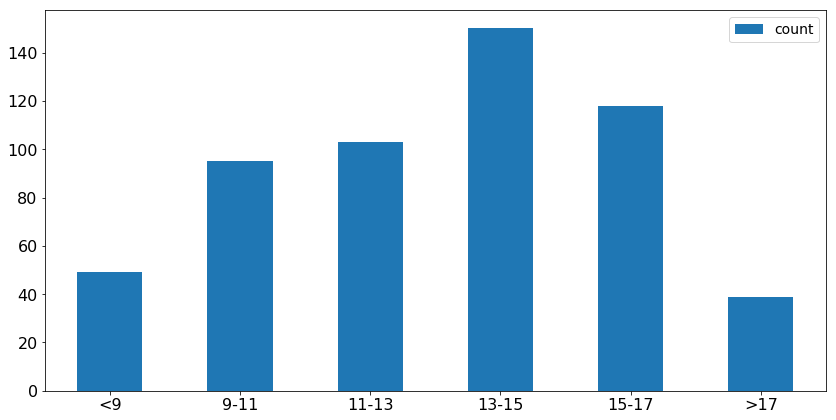

In [416]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ct = pd.DataFrame({'count': count_age}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [417]:


ageS9B = sqrt(mean_squared_error(ageS9.query_pb, ageS9.best_pb_prediction))
ageS9M = sqrt(mean_squared_error(ageS9.query_pb, ageS9.mean_pb_average_pace))

ageS11B = sqrt(mean_squared_error(ageS11.query_pb, ageS11.best_pb_prediction))
ageS11M = sqrt(mean_squared_error(ageS11.query_pb, ageS11.mean_pb_average_pace))

ageS13B = sqrt(mean_squared_error(ageS13.query_pb, ageS13.best_pb_prediction))
ageS13M = sqrt(mean_squared_error(ageS13.query_pb, ageS13.mean_pb_average_pace))

ageS15B = sqrt(mean_squared_error(ageS15.query_pb, ageS15.best_pb_prediction))
ageS15M = sqrt(mean_squared_error(ageS15.query_pb, ageS15.mean_pb_average_pace))

ageS17B = sqrt(mean_squared_error(ageS17.query_pb, ageS17.best_pb_prediction))
ageS17M = sqrt(mean_squared_error(ageS17.query_pb, ageS17.mean_pb_average_pace))

ageS19B = sqrt(mean_squared_error(ageS19.query_pb, ageS19.best_pb_prediction))
ageS19M = sqrt(mean_squared_error(ageS19.query_pb, ageS19.mean_pb_average_pace))


print('Aged 23-39 U9 Fastest Case Error:', ageS9B)
print('Aged 23-39 U9 Mean of Cases Error:', ageS9M)
print('Aged 23-39 9-11 Fastest Case Error:', ageS11B)
print('Aged 23-39 9-11 Mean of Cases Error:', ageS11M)
print('Aged 23-39 11-13 Fastest Case Error:', ageS13B)
print('Aged 23-39 11-13 Mean of Cases Error:', ageS13M)
print('Aged 23-39 13-15 Fastest Case Error:', ageS15B)
print('Aged 23-39 13-15 Mean of Cases Error:', ageS15M)
print('Aged 23-39 15-17 Fastest Case Error:', ageS17B)
print('Aged 23-39 15-17 Mean of Cases Error:', ageS17M)
print('Aged 23-39 O17 Fastest Case Error:', ageS19B)
print('Aged 23-39 017 Mean of Cases Error:', ageS19M)

Aged 23-39 U9 Fastest Case Error: 0.5028739650115996
Aged 23-39 U9 Mean of Cases Error: 1.106176696892701
Aged 23-39 9-11 Fastest Case Error: 1.427235544427088
Aged 23-39 9-11 Mean of Cases Error: 2.0542069324417107
Aged 23-39 11-13 Fastest Case Error: 1.4252845695662417
Aged 23-39 11-13 Mean of Cases Error: 1.763742159241237
Aged 23-39 13-15 Fastest Case Error: 1.8630919750796884
Aged 23-39 13-15 Mean of Cases Error: 1.2861109976455491
Aged 23-39 15-17 Fastest Case Error: 2.1875339591684977
Aged 23-39 15-17 Mean of Cases Error: 0.9094006719758916
Aged 23-39 O17 Fastest Case Error: 4.027213517863102
Aged 23-39 017 Mean of Cases Error: 2.339921979839834


In [418]:
mean_age = [ageS9M, ageS11M, ageS13M, ageS15M, ageS17M, ageS19M]
best_age = [ageS9B, ageS11B, ageS13B, ageS15B, ageS17B, ageS19B]

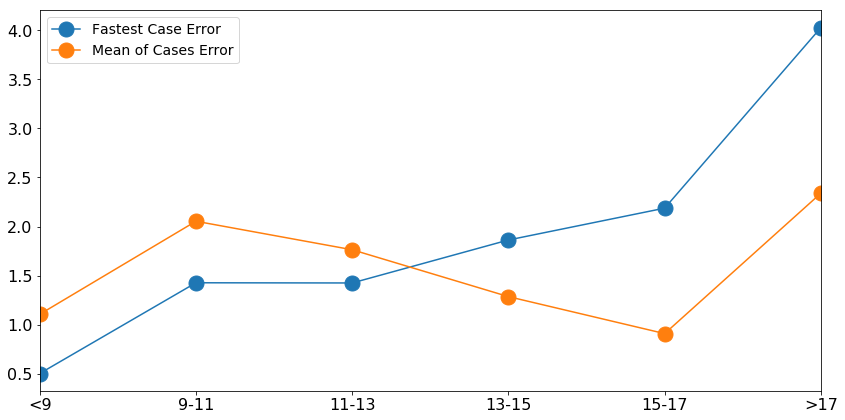

In [419]:
index = ['<9', '9-11', '11-13', '13-15', '15-17', '>17']
ag = pd.DataFrame({'Mean of Cases Error': mean_age, 'Fastest Case Error': best_age}, index=index)
ax = ag.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)

# AGE

In [420]:
g23 = [sen, senW]
g40 = [mas, wom1]
g50 = [mas2, wom2]
g60 = mas3
g20 = you

In [421]:
g23 = pd.concat(g23)
g40 = pd.concat(g40)
g50 = pd.concat(g50)

In [422]:
g23count = g23.shape[0]
g40count = g40.shape[0]
g50count = g50.shape[0]
g60count = g60.shape[0]
g20count = g20.shape[0]

In [423]:
count_G = [g20count, g23count, g40count, g50count, g60count]

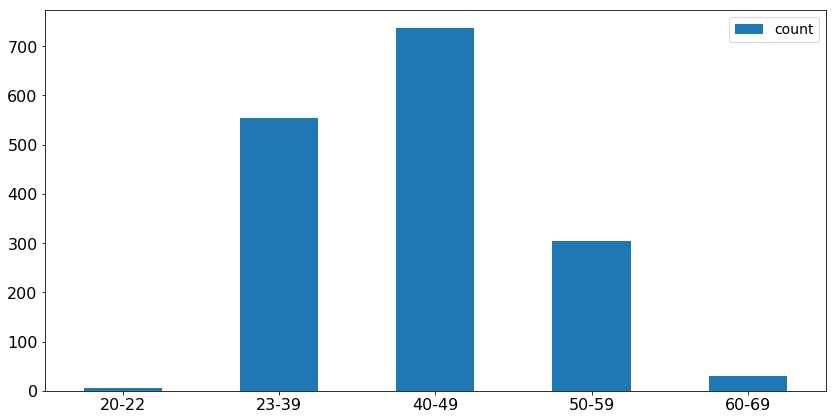

In [424]:
index = ['20-22', '23-39', '40-49', '50-59', '60-69']
ct = pd.DataFrame({'count': count_G}, index=index)
ax = ct.plot.bar(figsize=(14, 7), fontsize=16, rot=0)
ax.legend(fontsize = 14)

In [425]:


g23B = sqrt(mean_squared_error(g23.query_pb, g23.best_pb_prediction))
g23M = sqrt(mean_squared_error(g23.query_pb, g23.mean_pb_average_pace))

g40B = sqrt(mean_squared_error(g40.query_pb, g40.best_pb_prediction))
g40M = sqrt(mean_squared_error(g40.query_pb, g40.mean_pb_average_pace))

g50B = sqrt(mean_squared_error(g50.query_pb, g50.best_pb_prediction))
g50M = sqrt(mean_squared_error(g50.query_pb, g50.mean_pb_average_pace))

g60B = sqrt(mean_squared_error(g60.query_pb, g60.best_pb_prediction))
g60M = sqrt(mean_squared_error(g60.query_pb, g60.mean_pb_average_pace))


print('23-39 Fastest Case Error:', g23B)
print('23-39 Mean of Cases Error:', g23M)
print('40-49 Fastest Case Error:', g40B)
print('40-49 Mean of Cases Error:', g40M)
print('50-59 Fastest Case Error:', g50B)
print('50-59 Mean of Cases Error:', g50M)
print('60-69 Fastest Case Error:', g60B)
print('60-69 Mean of Cases Error:', g60M)

23-39 Fastest Case Error: 1.9621860720175257
23-39 Mean of Cases Error: 1.5555188891025966
40-49 Fastest Case Error: 2.046690706653104
40-49 Mean of Cases Error: 1.333364095892938
50-59 Fastest Case Error: 2.5638843098474573
50-59 Mean of Cases Error: 1.7126174127381422
60-69 Fastest Case Error: 1.928990909900508
60-69 Mean of Cases Error: 1.0418643704641304


In [426]:
mean_A = [g23M, g40M, g50M, g60M]
best_A = [g23B, g40B, g50B, g60B]

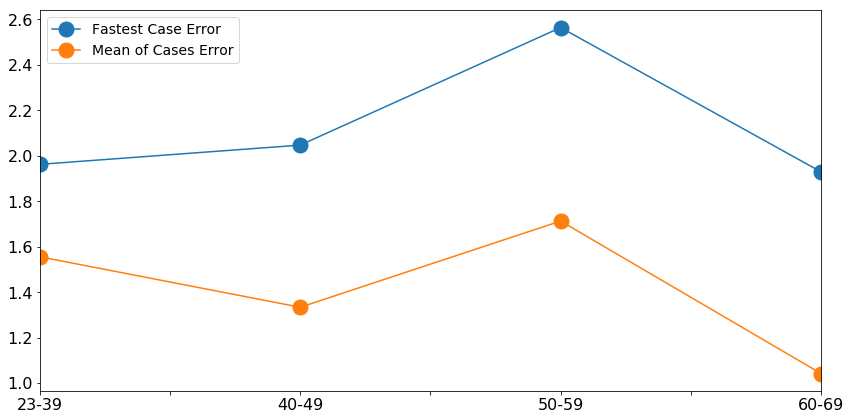

In [427]:
index = ['23-39', '40-49', '50-59', '60-69']
ageG = pd.DataFrame({'Mean of Cases Error': mean_A, 'Fastest Case Error': best_A}, index=index)
ax = ageG.plot(figsize=(14, 7), fontsize=16, rot=0, marker='o', ms=15)
ax.legend(fontsize = 14)